In [1]:
#Loading the dataset
data <- read.csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
 

In [2]:
library(pacman)

In [3]:
MYLIBRARIES<-c("caret",
               "dplyr",
               "data.table",
               "splitTools",
               "parallel",
               "parallelMap",
               "xgboost",
               'DiagrammeR',
               'rpart',
                'tree',
               'rpart.plot',
               'parallelMap',
               'parallel',
               "performanceEstimation")
pacman::p_load(char=MYLIBRARIES, install=TRUE, character.only = TRUE)

## Data Pre Processing

In [4]:
# create new dataset from  minus columns in the subset
df <- subset(data, select = -c(StandardHours, Over18 , EmployeeCount , EmployeeNumber,DailyRate,MonthlyRate) )

In [5]:
cols <- c("JobRole", "OverTime", "Department", "MaritalStatus",'Gender', 'Attrition' , 'EducationField','Education'
         ,'EnvironmentSatisfaction','JobLevel', 'JobInvolvement','JobSatisfaction','RelationshipSatisfaction',
          'StockOptionLevel','TrainingTimesLastYear','WorkLifeBalance')

In [6]:
#factor encode columns 
df[cols] <- lapply(df[cols], factor) 

In [7]:
#create new features work experience score and Attrition Score
df <- df %>% mutate(WorkExperienceScore = TotalWorkingYears/Age)
df <- df%>% mutate(AttritionScore = NumCompaniesWorked / (TotalWorkingYears + 1))

In [8]:
#round new columns work experience score and Attrition score to two decimal places
df$WorkExperienceScore = round(df$WorkExperienceScore, digits = 2)
df$AttritionScore =round(df$AttritionScore, digits = 2)

In [9]:
#Create new feature ManagersYearsLabel based on condition from years under current manager
df$ManagerYearsLabel <-
    ifelse(
      df$YearsWithCurrManager <= 1,
      'New Hire',
      ifelse(
        df$YearsWithCurrManager > 1 &
          df$YearsWithCurrManager <= 4,
        'Experenced Hire',
        'Verteran Hire'
      )
    )

In [10]:
#Remove more features no longer needed
df <- subset(df, select = -c(TotalWorkingYears , Age,NumCompaniesWorked ,YearsWithCurrManager) )

In [11]:
#Convert business travel to a factor with level 1,2,3
df$BusinessTravel <- factor(df$BusinessTravel,
                         levels = c('Travel_Frequently', 'Travel_Rarely', 'Non-Travel'),
                         labels = c(1, 2, 3))
 

In [12]:
#Convert manager label to factor
df$ManagerYearsLabel <- as.factor(df$ManagerYearsLabel)

In [13]:
#set seed for dataset and randomise dataset
set.seed(11)
df<-df[order(runif(nrow(df))),]


In [14]:
#train test splits using partition function (70 percent train , 30 percent test)
inds <- partition(df$Attrition, p = c(train = 0.7,test = 0.3))
train <- df[inds$train, ]
test <- df[inds$test, ]

In [15]:
#Smote oversampling on dataset
train_smote <- smote(Attrition ~ . , train, perc.over = 2, k = 3, perc.under = 1)

In [16]:
#write.csv(train,"../Desktop/train.preprocessed", row.names = FALSE)
#write.csv(test,"../Desktop/test.preprocessed", row.names = FALSE)

In [17]:
#Function to calculate accuracy of each model
model.accuracy <- function(table) {
 acc <- round((table[1,1] + table[2,2] ) / (table[1,1] + table[1,2] +table[2,1] + table[2,2]) , digits=2)
 return(acc)
}

In [18]:
#Function to calculate recall for yes cases of attrition
AttritionYes.recall <- function(table){
    rec <- round((table[2,2] ) / (table[2,2]+table[2,1]),digits=2)
    return(rec)
    }

In [19]:
#Function to calculate precision for yes cases of attrition
AttritionYes.precision <- function(table){
    prec <- round((table[2,2] ) / (table[2,2]+ table[1,2]) ,digits=2)
    return(prec)
    }

In [20]:
#Function to calculate recall for no cases of attrition
AttritionNo.recall <- function(table){
    rec <- round((table[1,1] ) / (table[1,1]+table[2,1]),digits=2)
    return(rec)
    }

In [21]:
#Function to calculate precision for no cases of attrition
AttritionNo.precision <- function(table){
    prec <- round((table[1,1] ) / (table[1,1]+ table[1,2]) ,digits=2)
    return(prec)
    }

In [22]:
#Function to calculate total precision of model 
total.precision <- function(table){
    prec <- round(((table[2,2] ) / (table[2,2]+ table[1,2]) 
                   + (table[1,1] ) / (table[1,1]+ table[1,2]) ) / 2 , digits=2)
    return(prec)
    }

In [23]:
#Function to calculate total recall of model 
total.recall <- function(table){
    prec <- round(((table[1,1] ) / (table[1,1]+ table[2,1]) 
                   + (table[2,2] ) / (table[2,2]+ table[2,1]) ) / 2 , digits=2)
    return(prec)
    }

## KNN One hot Encoding

In [24]:
#One hot encoding dataset using dummyVars
dummy <- dummyVars(" ~ .", data=df)
knndf <- data.frame(predict(dummy, newdata = df)) 

In [25]:
# remove attrition.no from one hot encoded dataset
knndf <- subset(knndf, select = -c(Attrition.No) )

In [26]:
#change name of Atrrition.Yes to Attrition
names(knndf)[names(knndf) == "Attrition.Yes"] <- "Attrition"

In [27]:
# Set Attrition value of 0 to No
#Set Attrition value of 1 to Yes
knndf["Attrition"][knndf["Attrition"] == 0] <- 'No'   
knndf["Attrition"][knndf["Attrition"] == 1] <- 'Yes'
 

In [28]:
#Factor Encode our target label attrition
knndf$Attrition <- as.factor(knndf$Attrition)

In [29]:
#Train Test splits to be used for knn modelling
knninds <- partition(knndf$Attrition, p = c(train = 0.7,  test = 0.3))
knntrain <- knndf[knninds$train, ]
knntest <- knndf[knninds$test, ]
#Smote oversampling applied to knn dataset used to train our data
knn.train_smote <- smote(Attrition ~ . , knntrain, perc.over = 2, k = 5, perc.under = 1)

## Hypertuned KNN

In [30]:
#method = repeatedcv -  Sets resampling method to repeated cross validation
# Number = 10        -  Sets cross validation fold to 10
#repeats = 3         -  Sets 10-fold cross-validations to reapeat 3 times
x = trainControl(method = 'repeatedcv',number = 10,repeats = 3)

In [31]:
knnmodel <- train(Attrition~. , data = knntrain, method = 'knn',#train knndata with method as knn and Target label Attrition
                preProcess = c('center','scale'), # center and scale dataset  to mean 0 and standard deviation 1
                trControl = x, #Train control method set to values previously stated(x)
                tuneGrid   = expand.grid(k = 1:20),# Grid Search for k values 1 to 20
                metric = 'Accuracy', # Sets metric for training model to Accuracy
                tuneLength = 10)  #Sets the number of different values to try for each tunning parameter.

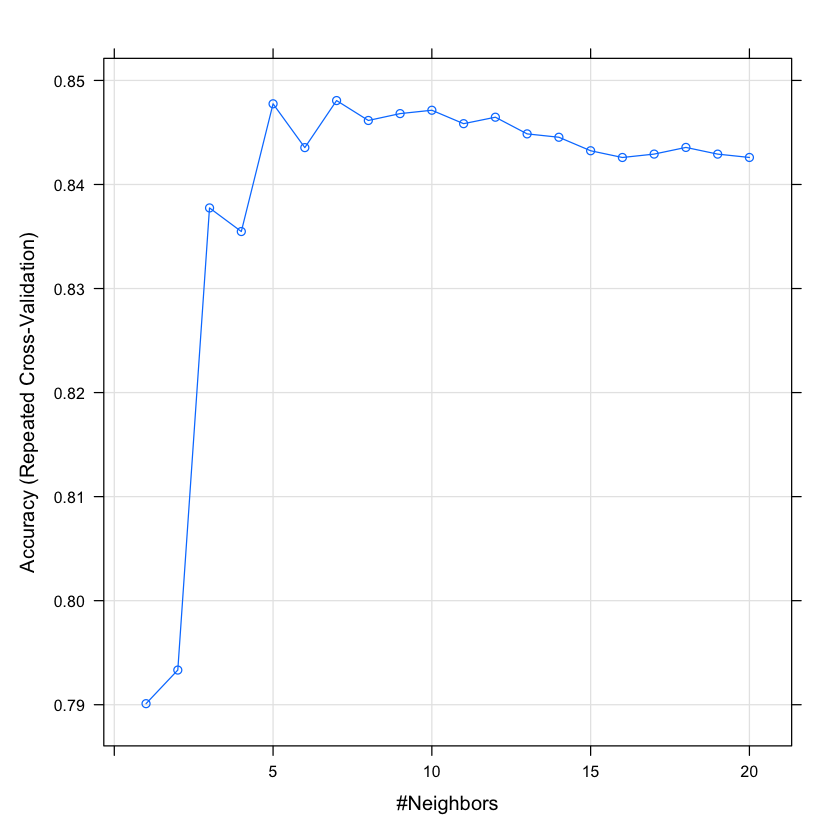

In [32]:
plot(knnmodel)

In [33]:
#predict model using test set
knnPredict <- predict(knnmodel ,  newdata = knntest )

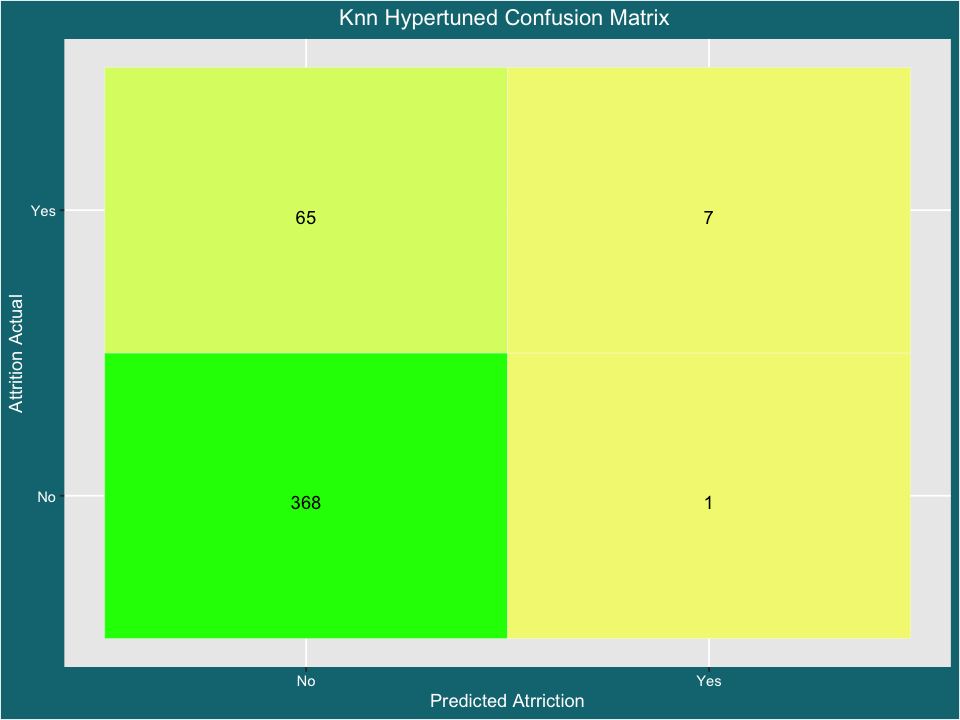

In [34]:
#customize width and height of plot
options(repr.plot.width=8, repr.plot.height=6) 

#store prediction results in a table 
conf_df <- data.frame(table(knntest$Attrition, knnPredict))
#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = knnPredict, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "green") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Knn Hypertuned Confusion Matrix ", y="Attrition Actual", x="Predicted Atrriction")

In [35]:
#store table of predicted and actual values
cm.knn<- table(knntest$Attrition, knnPredict)

In [36]:
#apply accuracy formula on table
knn.hypertunedaccuracy <- model.accuracy(cm.knn)

In [37]:
#apply recall formula on yes cases of attrtiion
knn.hypertunedrecallYes <- AttritionYes.recall(cm.knn)

In [38]:
#apply precision formula on yes cases of attrtiion
knn.hypertunedprecisionYes <- AttritionYes.precision(cm.knn)

In [39]:
#calculate F1 Score for yes cases of attrition and round to two decimal places
knn.hypertuned_F1ScoreYes <- round((2 * knn.hypertunedprecisionYes * knn.hypertunedrecallYes) / (knn.hypertunedrecallYes
                                                                                    +knn.hypertunedprecisionYes) ,digits=2)

In [40]:
#apply recall formula on no cases of attrtiion
knn.hypertunedrecallNo <- AttritionNo.recall(cm.knn)
#apply precision formula on no cases of attrtiion
knn.hypertunedprecisionNo <- AttritionNo.precision(cm.knn)

In [41]:
#calculate F1 Score for no cases of attrition and round to two decimal places
knn.hypertuned_F1ScoreNo <- round((2 * knn.hypertunedprecisionNo * knn.hypertunedrecallNo) / (knn.hypertunedrecallNo
                                                                                    +knn.hypertunedprecisionNo) ,digits=2)

In [42]:
#apply total precision formula(both cases of attrtiion)
total.precision.hypertuned_knn <- total.precision(cm.knn)

In [43]:
#apply total recall formula (both cases of attrtiion)
total.recall.hypertuned_knn <- total.recall(cm.knn)

In [44]:
#calculate total F1 score (both cases of attrtiion)
total.F1Scoreknn<- round((knn.hypertuned_F1ScoreNo + knn.hypertuned_F1ScoreYes)/2,digits=2)

## Smote Hypertuned KNN

In [45]:
smote.knnmodel <- train(Attrition~. , data = knn.train_smote, method = 'knn',#train knndata with method as knn and Target label Attrition
                preProcess = c('center','scale'), #center and scale dataset  to mean 0 and standard deviation 1
                trControl = x, #Train control method set to values previously stated(x)
                tuneGrid   = expand.grid(k = 1:20),
                metric = 'Accuracy', # Grid Search for k values 1 to 20
                tuneLength = 10) #Sets the number of different values to try for each tunning parameter.

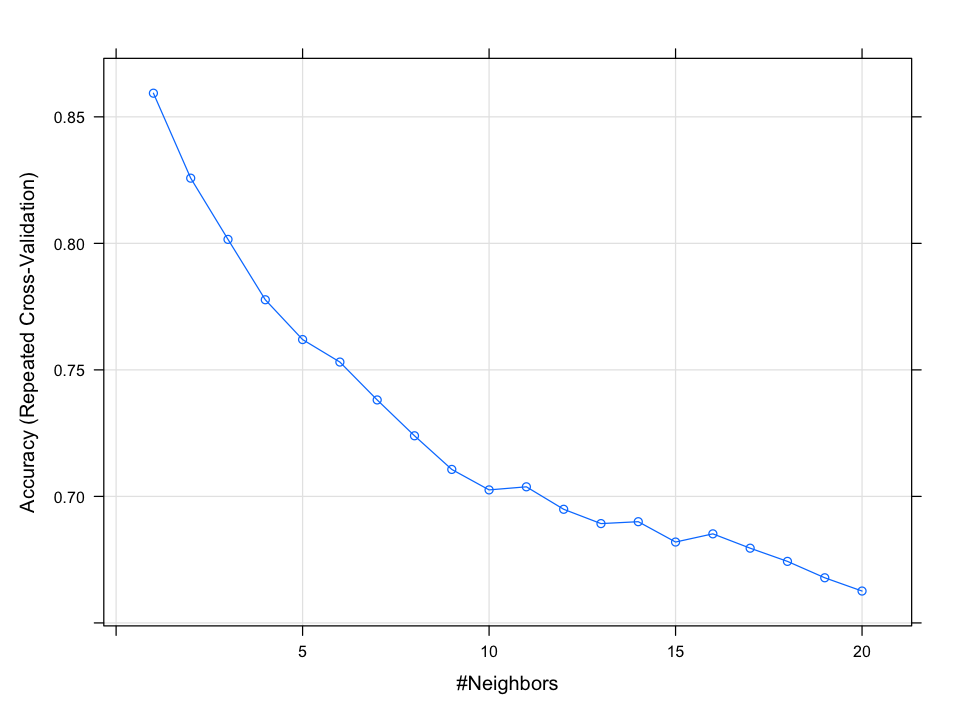

In [46]:
plot(smote.knnmodel)

In [47]:
#predict model using test set
smote.knnPredict <- predict(smote.knnmodel ,  newdata = knntest )

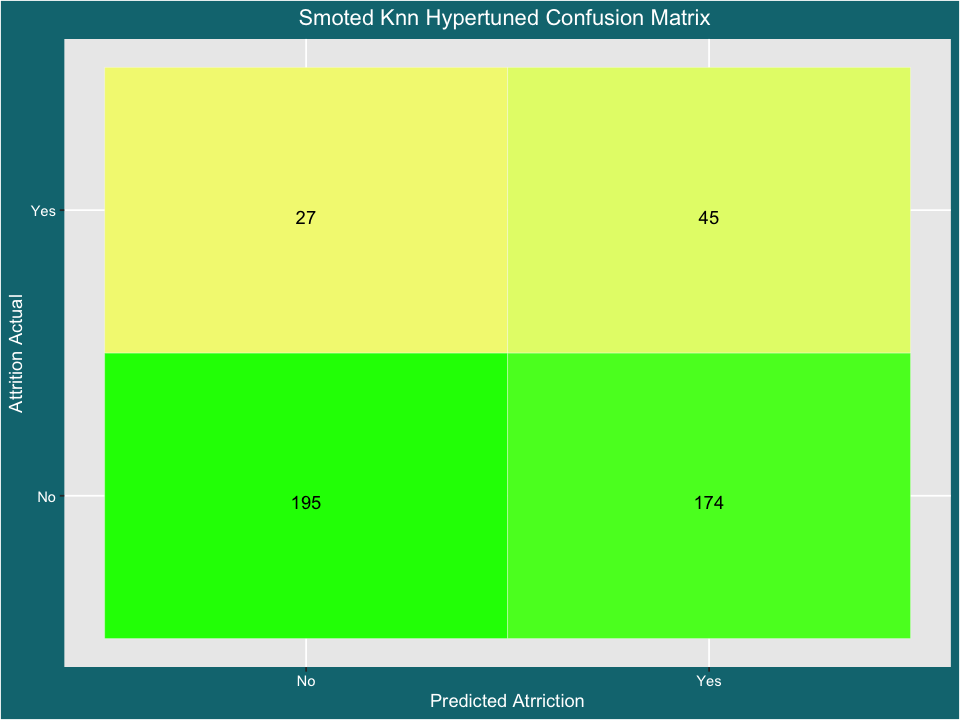

In [48]:
#customize width and height of plot
options(repr.plot.width=8, repr.plot.height=6) 

#store prediction results in a table 
conf_df <- data.frame(table(knntest$Attrition, smote.knnPredict))

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = smote.knnPredict, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "green") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Smoted Knn Hypertuned Confusion Matrix ", y="Attrition Actual", x="Predicted Atrriction")

In [49]:
#store table of predicted and actual values
cm.smoteknn<- table(knntest$Attrition, smote.knnPredict)

In [50]:
#apply accuracy formula on oversampled table
smote.knn.hypertunedaccuracy <- model.accuracy(cm.smoteknn)

In [51]:
#apply recall formula on yes cases of attrtiion
smote.knn.hypertunedrecallYes <- AttritionYes.recall(cm.smoteknn)

In [52]:
#apply precision formula on yes cases of attrtiion
smote.knn.hypertunedprecisionYes <- AttritionYes.precision(cm.smoteknn)

In [53]:
##calculate F1 Score for yes cases of attrtiion
smote.knn.hypertuned_F1ScoreYes <- round((2 * smote.knn.hypertunedprecisionYes * smote.knn.hypertunedrecallYes) / (smote.knn.hypertunedrecallYes
                                                                                    +smote.knn.hypertunedprecisionYes) ,digits=2)

In [54]:
#apply recall formula on no cases of attrtiion
smote.knn.hypertunedrecallNo <- AttritionNo.recall(cm.smoteknn)
#apply precision formula on no cases of attrtiion
smote.knn.hypertunedprecisionNo <- AttritionNo.precision(cm.smoteknn)

In [55]:
##calculate F1 Score for yes cases of attrtiion
smote.knn.hypertuned_F1ScoreNo <- round((2 * smote.knn.hypertunedprecisionNo * smote.knn.hypertunedrecallNo) / (smote.knn.hypertunedrecallNo
                                                                                    +smote.knn.hypertunedprecisionNo) ,digits=2)

In [56]:
#apply total recall formula (both cases of attrtiion)
total.recall.smote_knn <- total.recall(cm.smoteknn)

In [57]:
#apply total precision formula (both cases of attrtiion)
total.precision.smote_knn <- total.precision(cm.smoteknn)

In [58]:
#calculate total F1 Score(both cases of attrtiion)
total.F1Score.smote_knn<- round((smote.knn.hypertuned_F1ScoreNo + smote.knn.hypertuned_F1ScoreYes)/2,digits=2)

## Base Decision Tree

In [59]:
#Base decision tree cp set to 0 to show all trees
basetree <- rpart(
  Attrition ~. ,
  data = train, 
  method = "class" , control = rpart.control(cp = 0)
)

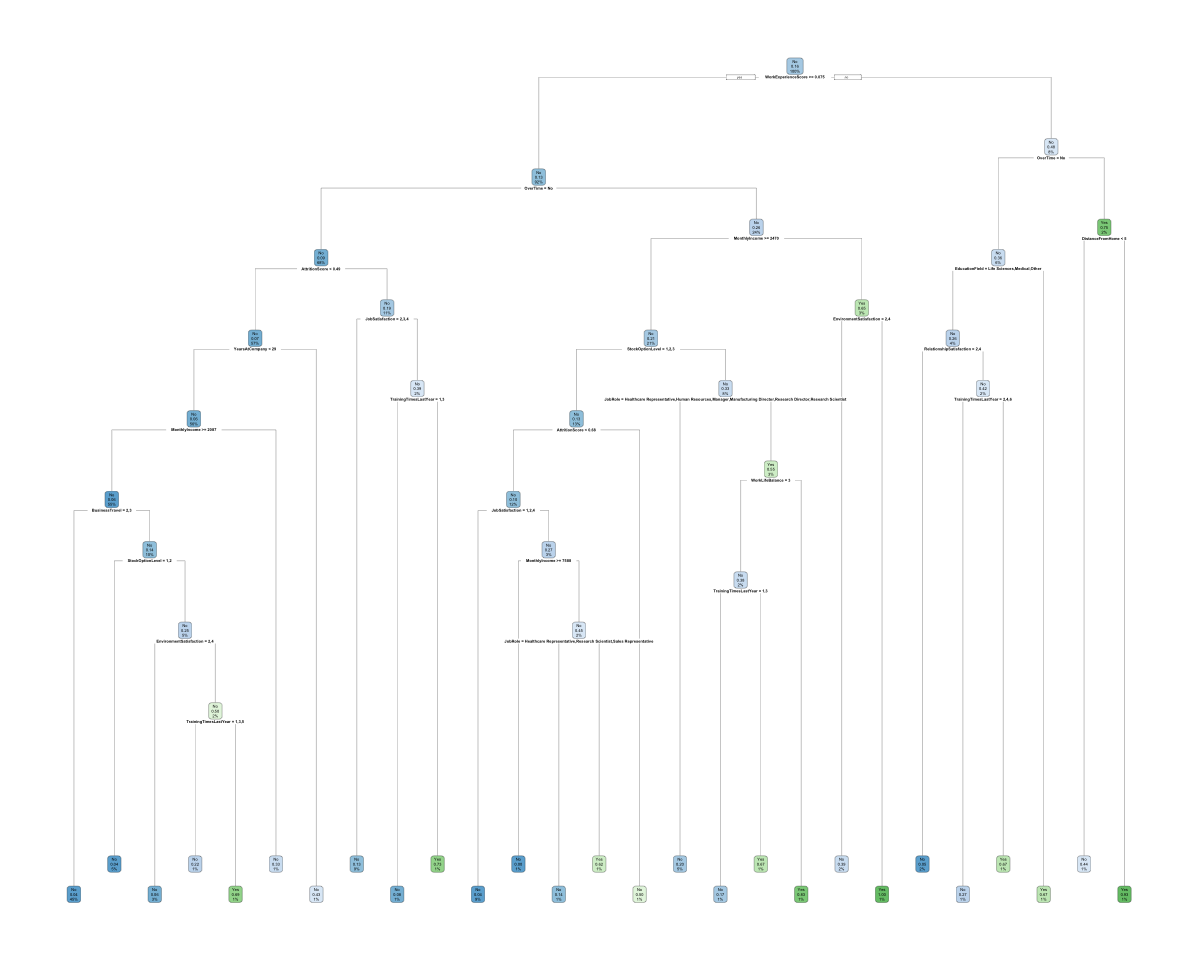

In [60]:
options(repr.plot.width=10, repr.plot.height=8) #customize width and height of plot
rpart.plot(basetree)                            #plot tree using rpart.plot library

In [61]:
#predict model using test set
base.preds <- predict(basetree, test, type="class")

In [62]:
#store table of predicted and actual values
cmdecisiontree.base <- table(test$Attrition, base.preds)

In [63]:
#apply accuracy formula on table
dectree.baseaccuracy <- model.accuracy(cmdecisiontree.base)

In [64]:
#apply recall formula on yes cases of attrtiion
dectree.baserecallYes <- AttritionYes.recall(cmdecisiontree.base)

In [65]:
#apply precision formula on yes cases of attrtiion
dectree.baseprecisionYes <- AttritionYes.precision(cmdecisiontree.base)

In [66]:
#calculate F1 Score for yes cases of attrtiion
dectree.base_F1ScoreYes <- round((2 * dectree.baseprecisionYes * dectree.baserecallYes) / (dectree.baserecallYes
                                                                                    +dectree.baseprecisionYes) ,digits=2)

In [67]:
#apply recall formula on no cases of attrtiion
dectree.baserecallNo <- AttritionNo.recall(cmdecisiontree.base)
#apply precision formula on no cases of attrtiion
dectree.baseprecisionNo <- AttritionNo.precision(cmdecisiontree.base)

In [68]:
#calculate F1 Score for no cases of attrtiion
dectree.base_F1ScoreNo <- round((2 * dectree.baseprecisionNo * dectree.baserecallNo) / (dectree.baserecallNo
                                                                                    +dectree.baseprecisionNo) ,digits=2)

In [69]:
#apply total recall formula (both cases of attrtiion)
total.recall.basetree <- total.recall(cmdecisiontree.base)
#apply total precision formula (both cases of attrtiion)
total.precision.basetree <- total.precision(cmdecisiontree.base)
#calculate total F1 Score(both cases of attrtiion)
total.F1Score.basetree<- round((dectree.base_F1ScoreNo + dectree.base_F1ScoreYes)/2,digits=2)

## Smote Base Decision Tree

In [70]:
#Oversampled decision tree cp set to 0 to show all trees
smotebasetree <- rpart(
  Attrition ~. ,
  data = train_smote, 
  method = "class" , control = rpart.control(cp = 0)
)

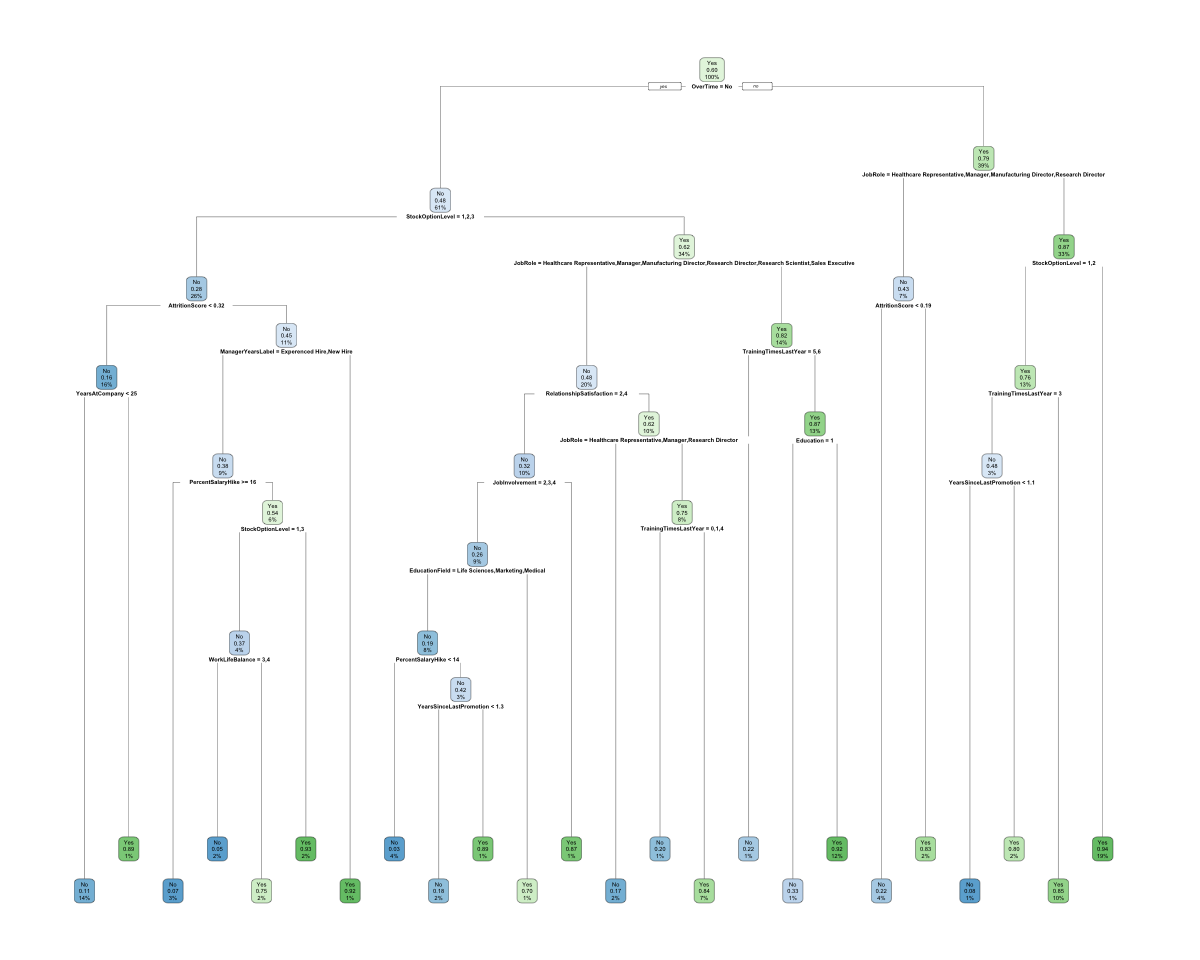

In [71]:
options(repr.plot.width=10, repr.plot.height=8) #customize width and height of plot
rpart.plot(smotebasetree)                       #plot tree using rpart.plot library

In [72]:
#predict model using test set
smotebase.preds <- predict(smotebasetree, test, type="class")

In [73]:
#store table of predicted and actual values
cm.smotedecisiontree.base <- table(test$Attrition, smotebase.preds)

In [74]:
#apply accuracy formula on table
smote.dectree.baseaccuracy <- model.accuracy(cm.smotedecisiontree.base)

In [75]:
#apply recall formula on yes cases of attrtiion
smote.dectree.baserecallYes <- AttritionYes.recall(cm.smotedecisiontree.base)

In [76]:
#apply precision formula on yes cases of attrtiion
smote.dectree.baseprecisionYes <- AttritionYes.precision(cm.smotedecisiontree.base)

In [77]:
# calculate F1 Score for yes cases of attrtiion
smote.dectree.base_F1ScoreYes <- round((2 * smote.dectree.baseprecisionYes * smote.dectree.baserecallYes) / (smote.dectree.baserecallYes
                                                                                    +smote.dectree.baseprecisionYes) ,digits=2)

In [78]:
#apply recall formula on no cases of attrtiion
smote.dectree.baserecallNo <- AttritionNo.recall(cm.smotedecisiontree.base)
#apply precision formula on yes cases of attrtiion
smote.dectree.baseprecisionNo <- AttritionNo.precision(cm.smotedecisiontree.base)

In [79]:
# calculate F1 Score for no cases of attrtiion
smote.dectree.base_F1ScoreNo <- round((2 * smote.dectree.baseprecisionNo * smote.dectree.baserecallNo) / (smote.dectree.baserecallNo
                                                                                    +smote.dectree.baseprecisionNo) ,digits=2)

In [80]:
total.recall.smote_basetree <- total.recall(cm.smotedecisiontree.base) #apply total recall formula (both cases of attrtiion)
total.precision.smote_basetree <- total.precision(cm.smotedecisiontree.base) #apply total precision formula (both cases of attrtiion)
total.F1Score.smote_basetree<- round((smote.dectree.base_F1ScoreNo + smote.dectree.base_F1ScoreYes)/2,digits=2) #calulate combined F1 score (both cases of attrtiion)

## Hypertuned / Pre Pruning decision tree

In [81]:
#load mlr using pacman .Note(has to be loaded here as it interfers with some other packages)
pacman::p_load(char='mlr', install=TRUE, character.only = TRUE)

In [82]:
tune.model<- makeClassifTask(data = train, target = "Attrition" ) # Convert training data to a classifcation task and store as new variable
tune.tree <- makeLearner("classif.rpart") # Sets learner for our classifcation task to rpart(decision tree) 

In [83]:
#define hypertune parameters to be used
treeParamSpace <- makeParamSet(
  makeIntegerParam("minsplit", lower = 0, upper = 10),# Minimum Split ranging from 0 to 10
  makeIntegerParam("minbucket", lower = 0, upper = 10), # Minimum Bucket ranging from 0 to 10
  makeNumericParam("cp", lower = 0.01, upper = 0.1), #Complexity Parameter(cp) ranging from 0.01 to 0.1
  makeIntegerParam("maxdepth", lower = 3, upper =5)) #maximum tree depth ranging from 3 to 5

In [84]:
randSearch <- makeTuneControlRandom(maxit = 20) # sets the maximum iterations used for random search
cvForTuning <- makeResampleDesc("CV", iters = 10) # sets resampling method to a 10 fold cross validation

In [85]:
#training task hypertuned/cross validated and ran in parallel
tunedTreePars <- tuneParams(tune.tree, task = tune.model, #classification task using decision tree
                            resampling = cvForTuning, # resampling strategy to be used based on previously defined input
                            par.set = treeParamSpace, # Parameter set to be used based on previously defined input
                            control = randSearch)     #control strategy to be used based on previously defined input

parallelStop() # stop parallel run

[Tune] Started tuning learner classif.rpart for parameter set:

             Type len Def      Constr Req Tunable Trafo
minsplit  integer   -   -     0 to 10   -    TRUE     -
minbucket integer   -   -     0 to 10   -    TRUE     -
cp        numeric   -   - 0.01 to 0.1   -    TRUE     -
maxdepth  integer   -   -      3 to 5   -    TRUE     -

With control class: TuneControlRandom

Imputation value: 1

[Tune-x] Setting hyperpars failed: Error in setHyperPars2.Learner(learner, insert(par.vals, args)) : 
  0 is not feasible for parameter 'minsplit'!


[Tune-x] 1: minsplit=0; minbucket=5; cp=0.0753; maxdepth=4

[Tune-y] 1: mmce.test.mean=      NA; time: 0.0 min

[Tune-x] 2: minsplit=5; minbucket=5; cp=0.0113; maxdepth=5

[Tune-y] 2: mmce.test.mean=0.1556825; time: 0.0 min

[Tune-x] 3: minsplit=6; minbucket=7; cp=0.0753; maxdepth=5

[Tune-y] 3: mmce.test.mean=0.1605178; time: 0.0 min

[Tune-x] 4: minsplit=2; minbucket=8; cp=0.0744; maxdepth=3

[Tune-y] 4: mmce.test.mean=0.1605178; time: 0.0

In [86]:
tunedTree <- setHyperPars(tune.tree, par.vals = tunedTreePars$x) # set hyper parameters to best parameters from hypertuning/cross validation
tunedTreeModel <- train(tunedTree, tune.model)                   # train model using those parameters 
treeModelData <- getLearnerModel(tunedTreeModel)                 # Get underlying R model of learner integrated into mlr

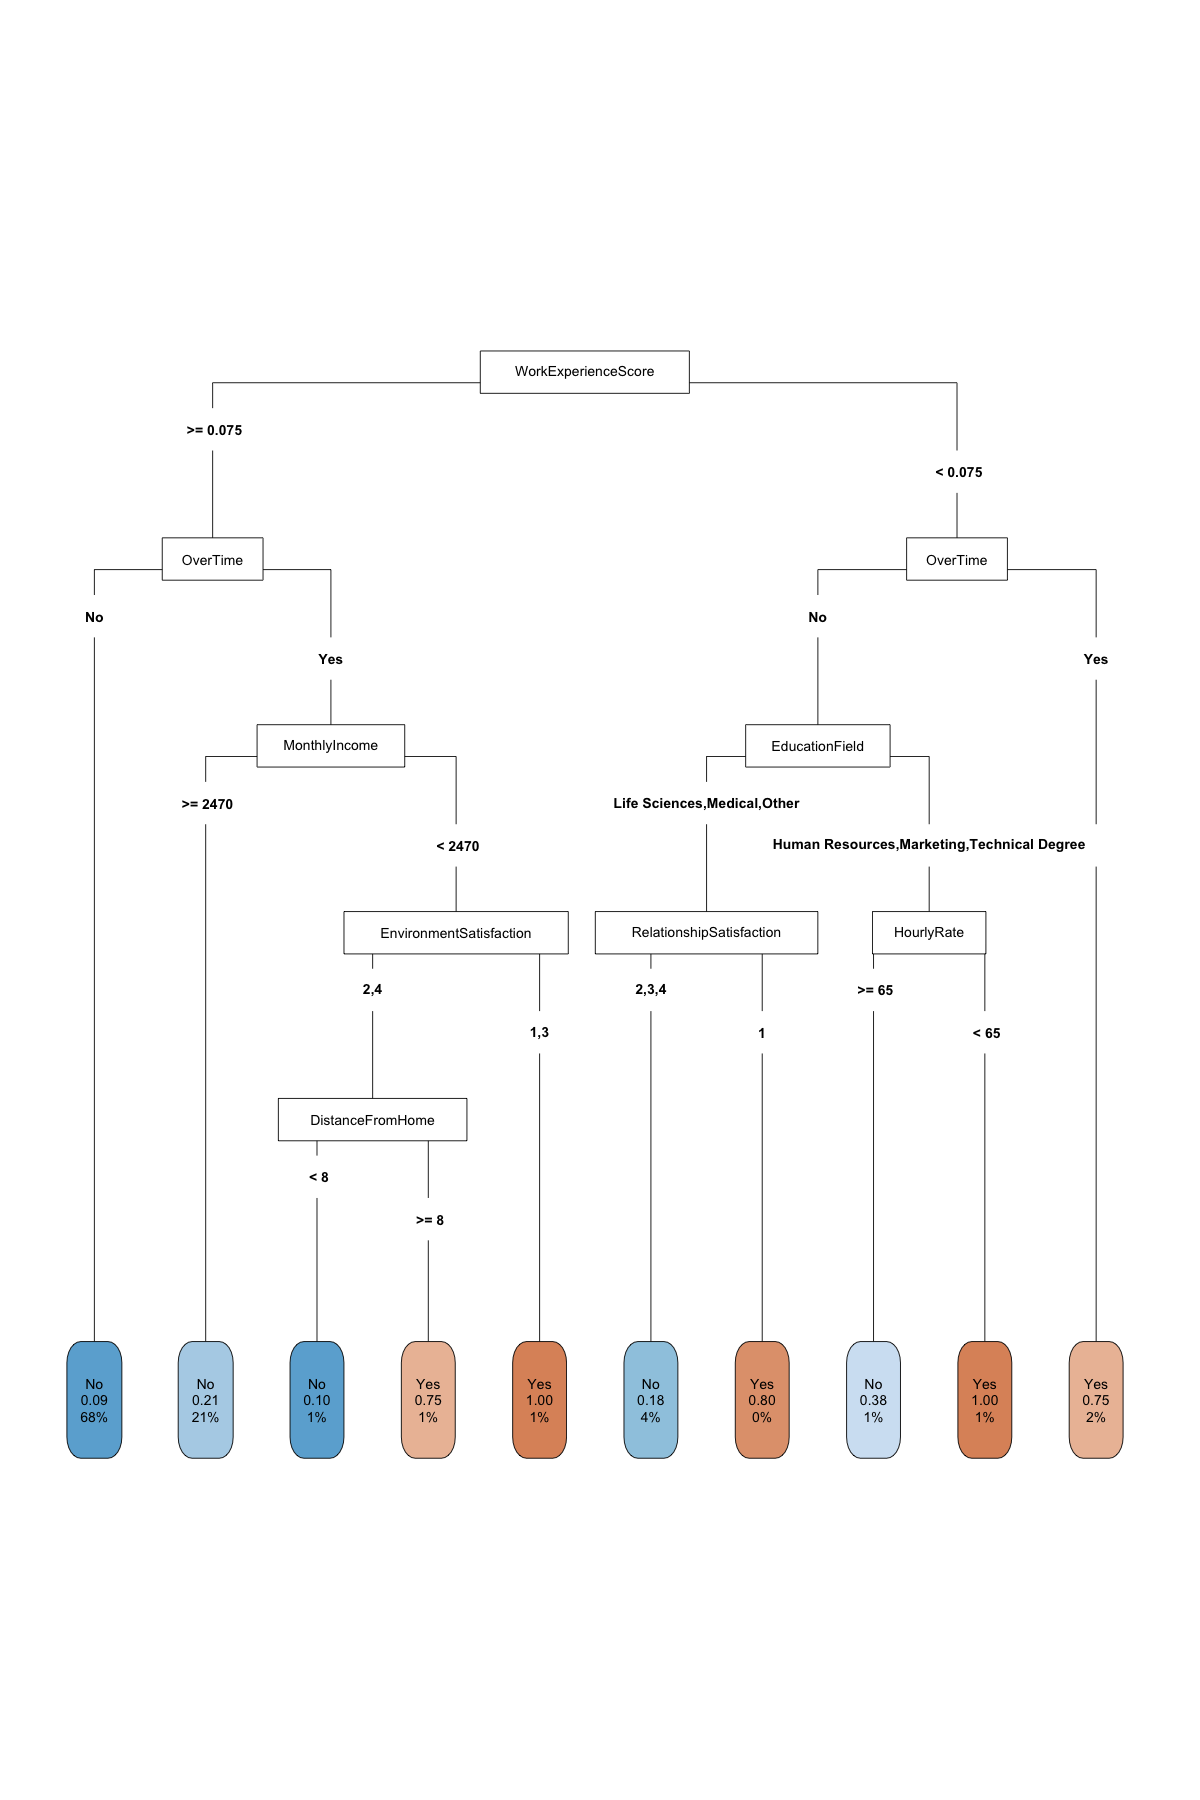

In [87]:
options(repr.plot.width=10, repr.plot.height=15) #customize width and height of plot
rpart.plot(treeModelData, roundint = FALSE,      ##plot tree using rpart.plot library
box.palette = "BuBn",
type = 5)

In [88]:
#predict model using test set
hypertunetree.preds<- predict(treeModelData, test, type="class")

In [89]:
#store table of predicted and actual values
cmdecisiontree.tuned <- table(test$Attrition, hypertunetree.preds)

In [90]:
#apply accuracy formula on table
dectree.hypertunedaccuracy <- model.accuracy(cmdecisiontree.tuned)

In [91]:
#apply recall formula on yes cases of attrtiion
dectree.hypertunedrecallYes <- AttritionYes.recall(cmdecisiontree.tuned)

In [92]:
#apply precision formula on yes cases of attrtiion
dectree.hypertunedprecisionYes <- AttritionYes.precision(cmdecisiontree.tuned)

In [93]:
#calculate F1 Score for yes cases of attrtiion
dectree.hypertuned_F1ScoreYes <- round((2 * dectree.hypertunedprecisionYes * dectree.hypertunedrecallYes) / (dectree.hypertunedrecallYes
                                                                                    +dectree.hypertunedprecisionYes) ,digits=2)

In [94]:
#apply recall formula on no cases of attrtiion
dectree.hypertunedrecallNo <- AttritionNo.recall(cmdecisiontree.tuned)
#apply precision formula on no cases of attrtiion
dectree.hypertunedprecisionNo <- AttritionNo.precision(cmdecisiontree.tuned)

In [95]:
#calculate F1 Score for no cases of attrtiion
dectree.hypertuned_F1ScoreNo <- round((2 * dectree.hypertunedprecisionNo * dectree.hypertunedrecallNo) / (dectree.hypertunedrecallNo
                                                                                    +dectree.hypertunedprecisionNo) ,digits=2)

In [96]:
total.recall.hypertunedtree <- total.recall(cmdecisiontree.tuned) #apply total recall formula (both cases of attrtiion)
total.precision.hypertunedtree <- total.precision(cmdecisiontree.tuned)  #apply total precision formula (both cases of attrtiion)
total.F1Score.hypertunedtree<- round((dectree.hypertuned_F1ScoreNo + dectree.hypertuned_F1ScoreYes)/2,digits=2) #calulate combined F1 score (both cases of attrtiion)

## Smote Hypertuned / Pre Pruning decision tree

In [97]:
smote.model<- makeClassifTask(data = train_smote, target = "Attrition" ) # Convert training data to a classifcation task and store as new variable
smote.tree <- makeLearner("classif.rpart")  # Sets learner for our classifcation task to rpart(decision tree) 

In [98]:
smote.tunedTreePars <- tuneParams(smote.tree, task = smote.model, #classification task using decision tree
                            resampling = cvForTuning, # resampling strategy to be used based on previously defined input
                            par.set = treeParamSpace, # Parameter set to be used based on previously defined input
                            control = randSearch)  #control strategy to be used based on previously defined input


parallelStop()  # stop parallel run


[Tune] Started tuning learner classif.rpart for parameter set:

             Type len Def      Constr Req Tunable Trafo
minsplit  integer   -   -     0 to 10   -    TRUE     -
minbucket integer   -   -     0 to 10   -    TRUE     -
cp        numeric   -   - 0.01 to 0.1   -    TRUE     -
maxdepth  integer   -   -      3 to 5   -    TRUE     -

With control class: TuneControlRandom

Imputation value: 1

[Tune-x] 1: minsplit=3; minbucket=5; cp=0.0874; maxdepth=4

[Tune-y] 1: mmce.test.mean=0.3030708; time: 0.0 min

[Tune-x] 2: minsplit=4; minbucket=2; cp=0.0164; maxdepth=4

[Tune-y] 2: mmce.test.mean=0.2713929; time: 0.0 min

[Tune-x] 3: minsplit=9; minbucket=5; cp=0.0258; maxdepth=4

[Tune-y] 3: mmce.test.mean=0.2666030; time: 0.0 min

[Tune-x] 4: minsplit=1; minbucket=4; cp=0.0368; maxdepth=5

[Tune-y] 4: mmce.test.mean=0.2812371; time: 0.0 min

[Tune-x] Setting hyperpars failed: Error in setHyperPars2.Learner(learner, insert(par.vals, args)) : 
  0 is not feasible for parameter 'minbuc

In [99]:
smote.tunedTree <- setHyperPars(smote.tree, par.vals = smote.tunedTreePars$x) # set hyper parameters to best parameters from hypertuning/cross validation
smote.tunedTreeModel <- train(smote.tunedTree, smote.model)   # train model using those parameters 
smote.treeModelData <- getLearnerModel(smote.tunedTreeModel)  # Get underlying R model of learner integrated into mlr

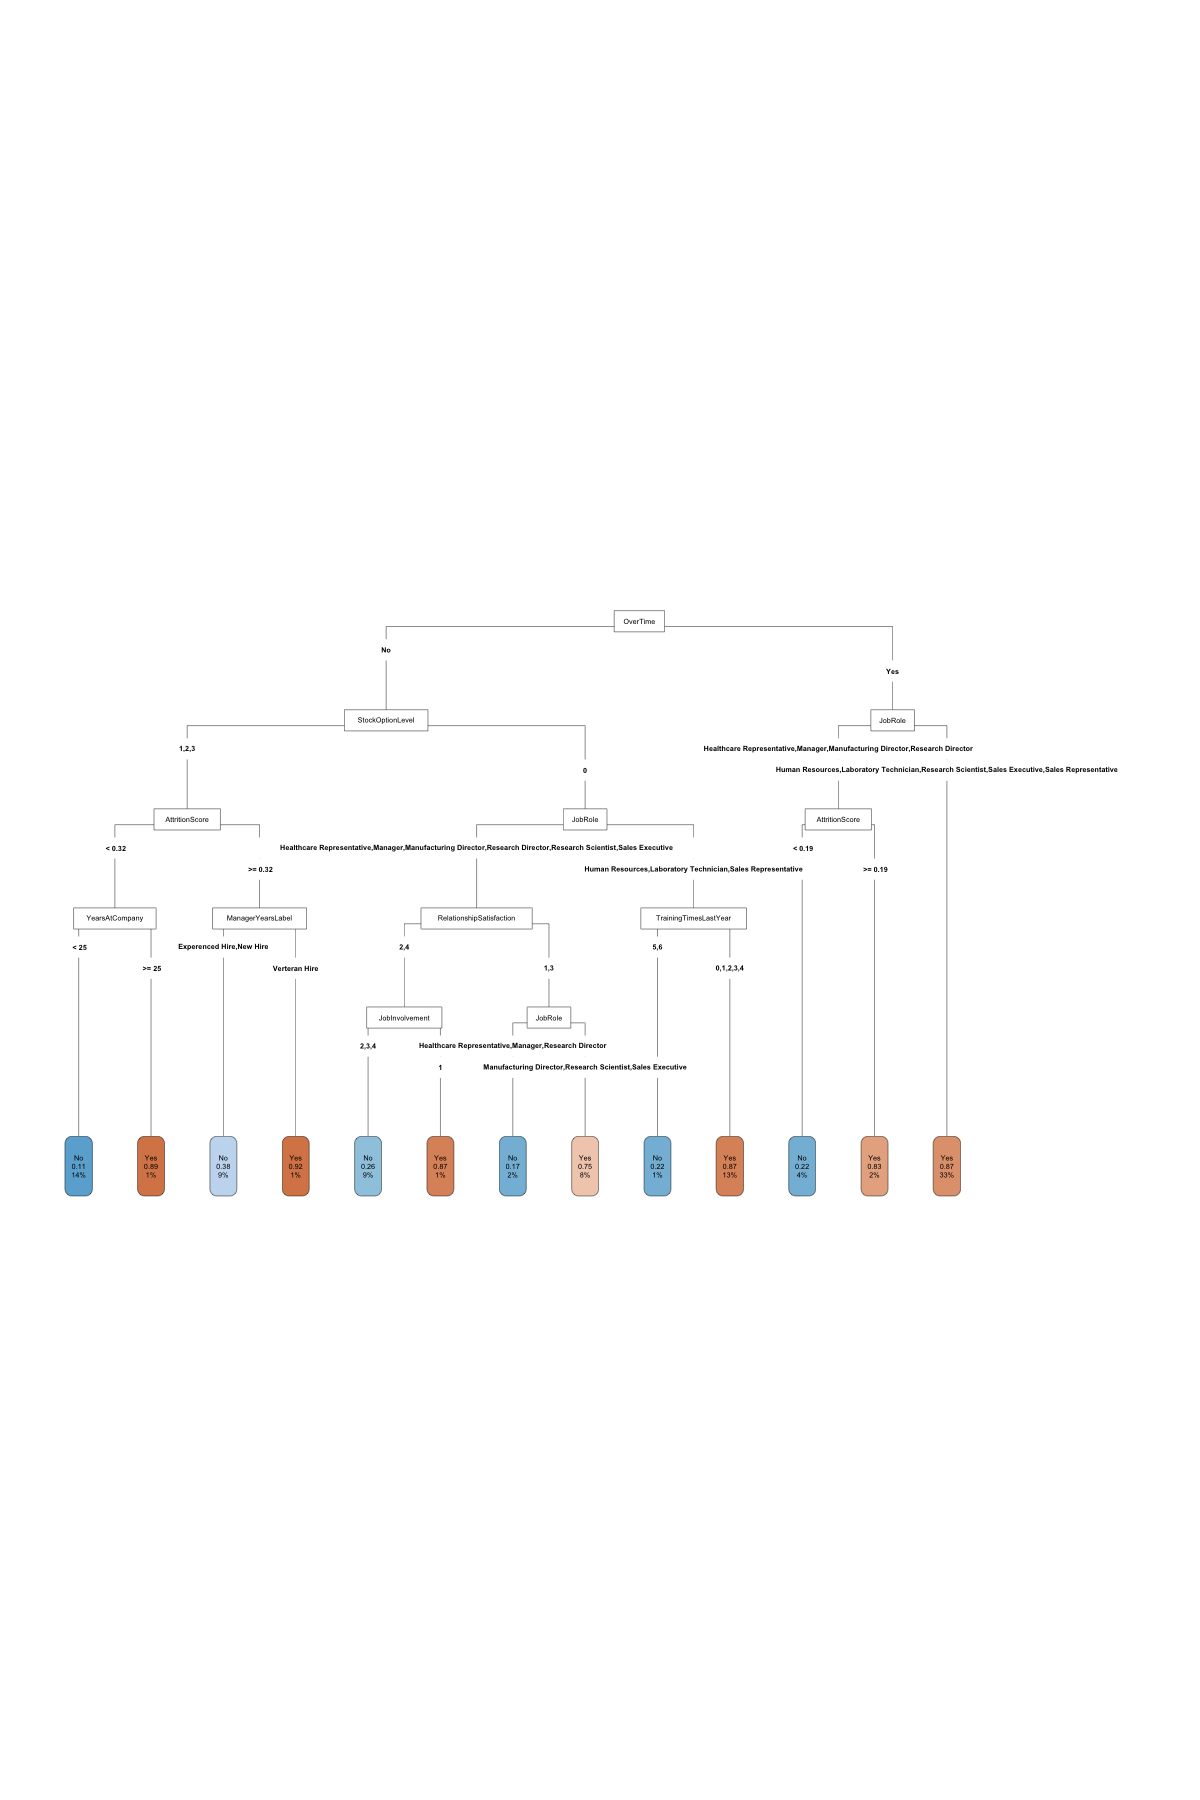

In [100]:
options(repr.plot.width=10, repr.plot.height=15) #customize width and height of plot
rpart.plot(smote.treeModelData, roundint = FALSE,  #plot tree using rpart.plot library
box.palette = "BuBn",
type = 5)

In [101]:
#predict model using test set
smote.hypertunetree.preds<- predict(smote.treeModelData, test, type="class")

In [102]:
#store table of predicted and actual values
smote.cmdecisiontree.tuned <- table(test$Attrition, smote.hypertunetree.preds)

In [103]:
#apply accuracy formula on table
smote.dectree.hypertunedaccuracy <- model.accuracy(smote.cmdecisiontree.tuned)

In [104]:
#apply recall formula on yes cases of attrtiion
smote.dectree.hypertunedrecallYes <- AttritionYes.recall(smote.cmdecisiontree.tuned)

In [105]:
#apply precision formula on yes cases of attrtiion
smote.dectree.hypertunedprecisionYes <- AttritionYes.precision(smote.cmdecisiontree.tuned)

In [106]:
#calculate F1 Score for yes cases of attrtiion
smote.dectree.hypertuned_F1ScoreYes <- round((2 * smote.dectree.hypertunedprecisionYes * smote.dectree.hypertunedrecallYes) / (smote.dectree.hypertunedrecallYes
                                                                                    +smote.dectree.hypertunedprecisionYes) ,digits=2)

In [107]:
smote.dectree.hypertunedrecallNo <- AttritionNo.recall(smote.cmdecisiontree.tuned) #apply recall formula on no cases of attrtiion
smote.dectree.hypertunedprecisionNo <- AttritionNo.precision(smote.cmdecisiontree.tuned) #apply precision formula on no cases of attrtiion

In [108]:
#calculate F1 Score for no cases of attrtiion
smote.dectree.hypertuned_F1ScoreNo <- round((2 * smote.dectree.hypertunedprecisionNo * smote.dectree.hypertunedrecallNo) / (smote.dectree.hypertunedrecallNo
                                                                                    +smote.dectree.hypertunedprecisionNo) ,digits=2)

In [109]:
total.recall.smote.hypertunedtree <- total.recall(smote.cmdecisiontree.tuned)#apply total recall formula (both cases of attrtiion)
total.precision.smote.hypertunedtree <- total.precision(smote.cmdecisiontree.tuned)#apply total recall formula (both cases of attrtiion)
total.F1Score.smote.hypertunedtree<- round((smote.dectree.hypertuned_F1ScoreNo + 
                                            smote.dectree.hypertuned_F1ScoreYes)/2,digits=2)#calculate total F1 score (both cases of attrtiion)

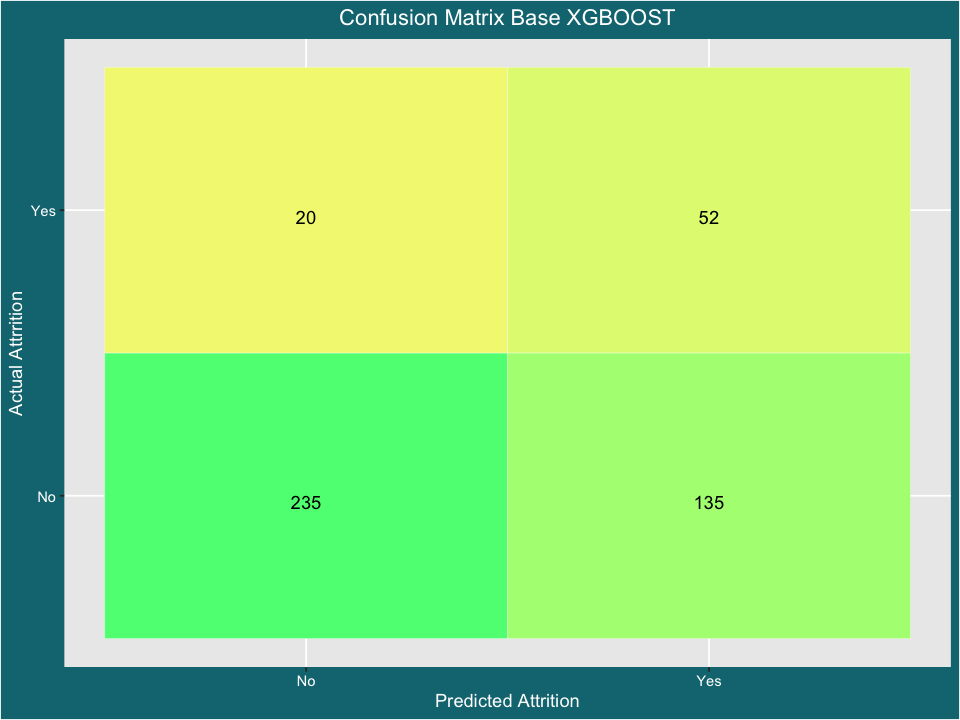

In [110]:
#customize height and width of plot
options(repr.plot.width=8, repr.plot.height=6) 
 
conf_df <- data.frame(table(test$Attrition, smote.hypertunetree.preds)) #store prediction results in a table 

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = smote.hypertunetree.preds, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "#58FA82") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix Base XGBOOST", y="Actual Attrrition", x="Predicted Attrition")

## Post Pruning Base Tree

In [111]:
postprune.tree <- prune(basetree, cp = 0.03 ) # prune base tree with complexity parameter set to 0.03

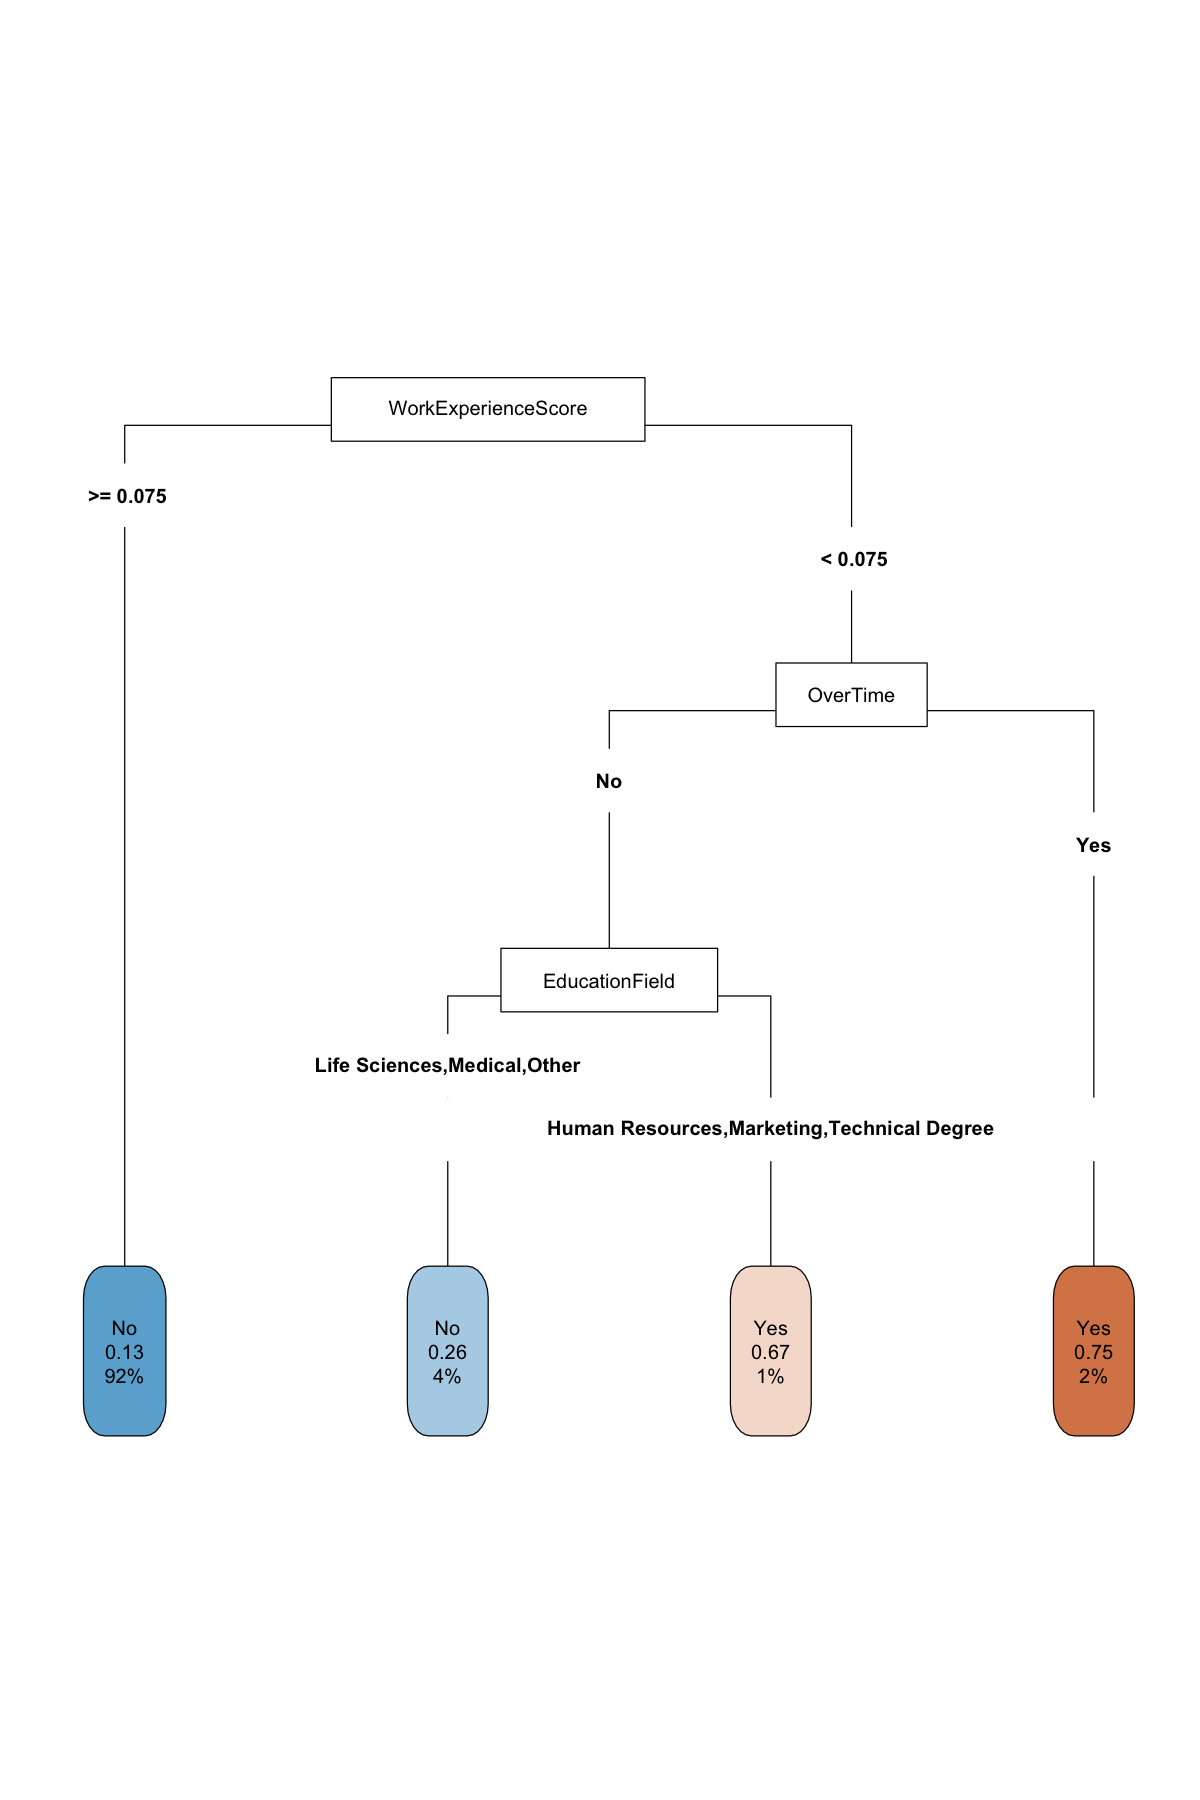

In [112]:
options(repr.plot.width=10, repr.plot.height=15) ##customize height and width of plot
rpart.plot(postprune.tree, roundint = FALSE, #plot tree using rpart.plot library
box.palette = "BuBn",
type = 5)

In [113]:
#predict model using test set
postprune.preds <- predict(postprune.tree, test, type="class")

In [114]:
#store table of predicted and actual values
cm.postprunetree <- table(test$Attrition, postprune.preds)

In [115]:
#apply accuracy formula on table
postprunetree.baseaccuracy <- model.accuracy(cm.postprunetree )

In [116]:
#apply recall formula on yes cases of attrtiion
postprunetree.baserecallYes <- AttritionYes.recall(cm.postprunetree)

In [117]:
#apply precision formula on yes cases of attrtiion
postprunetree.baseprecisionYes <- AttritionYes.precision(cm.postprunetree)

In [118]:
#calculate F1 Score for yes cases of attrtiion
postprunetree.base_F1ScoreYes <- round((2 * postprunetree.baseprecisionYes * postprunetree.baserecallYes) / (postprunetree.baserecallYes
                                                                    +postprunetree.baseprecisionYes) ,digits=2)

In [119]:
postprunetree.baserecallNo <- AttritionNo.recall(cm.postprunetree) #apply recall formula on no cases of attrtiion
postprunetree.baseprecisionNo <- AttritionNo.precision(cm.postprunetree) #apply precision formula on no cases of attrtiion


In [120]:
#calculate F1 Score for no cases of attrtiion
postprunetree.base_F1ScoreNo <- round((2 * postprunetree.baseprecisionNo * postprunetree.baserecallNo) / (postprunetree.baserecallNo
                                                                    +postprunetree.baseprecisionNo) ,digits=2)

In [121]:
total.recall.postprunetree <- total.recall(cm.postprunetree) #apply total recall formula (both cases of attrtiion)
total.precision.postprunetree <- total.precision(cm.postprunetree)#apply total precision formula (both cases of attrtiion)
total.F1Score.postprunetree<- round((postprunetree.base_F1ScoreYes + postprunetree.base_F1ScoreNo)/2,digits=2) #calculate total F1 score (both cases of attrtiion)

## Smote Post Pruning Base Tree

In [122]:
smote.postprune.tree <- prune(smotebasetree, cp = 0.03 ) # prune base tree with complexity parameter set to 0.03

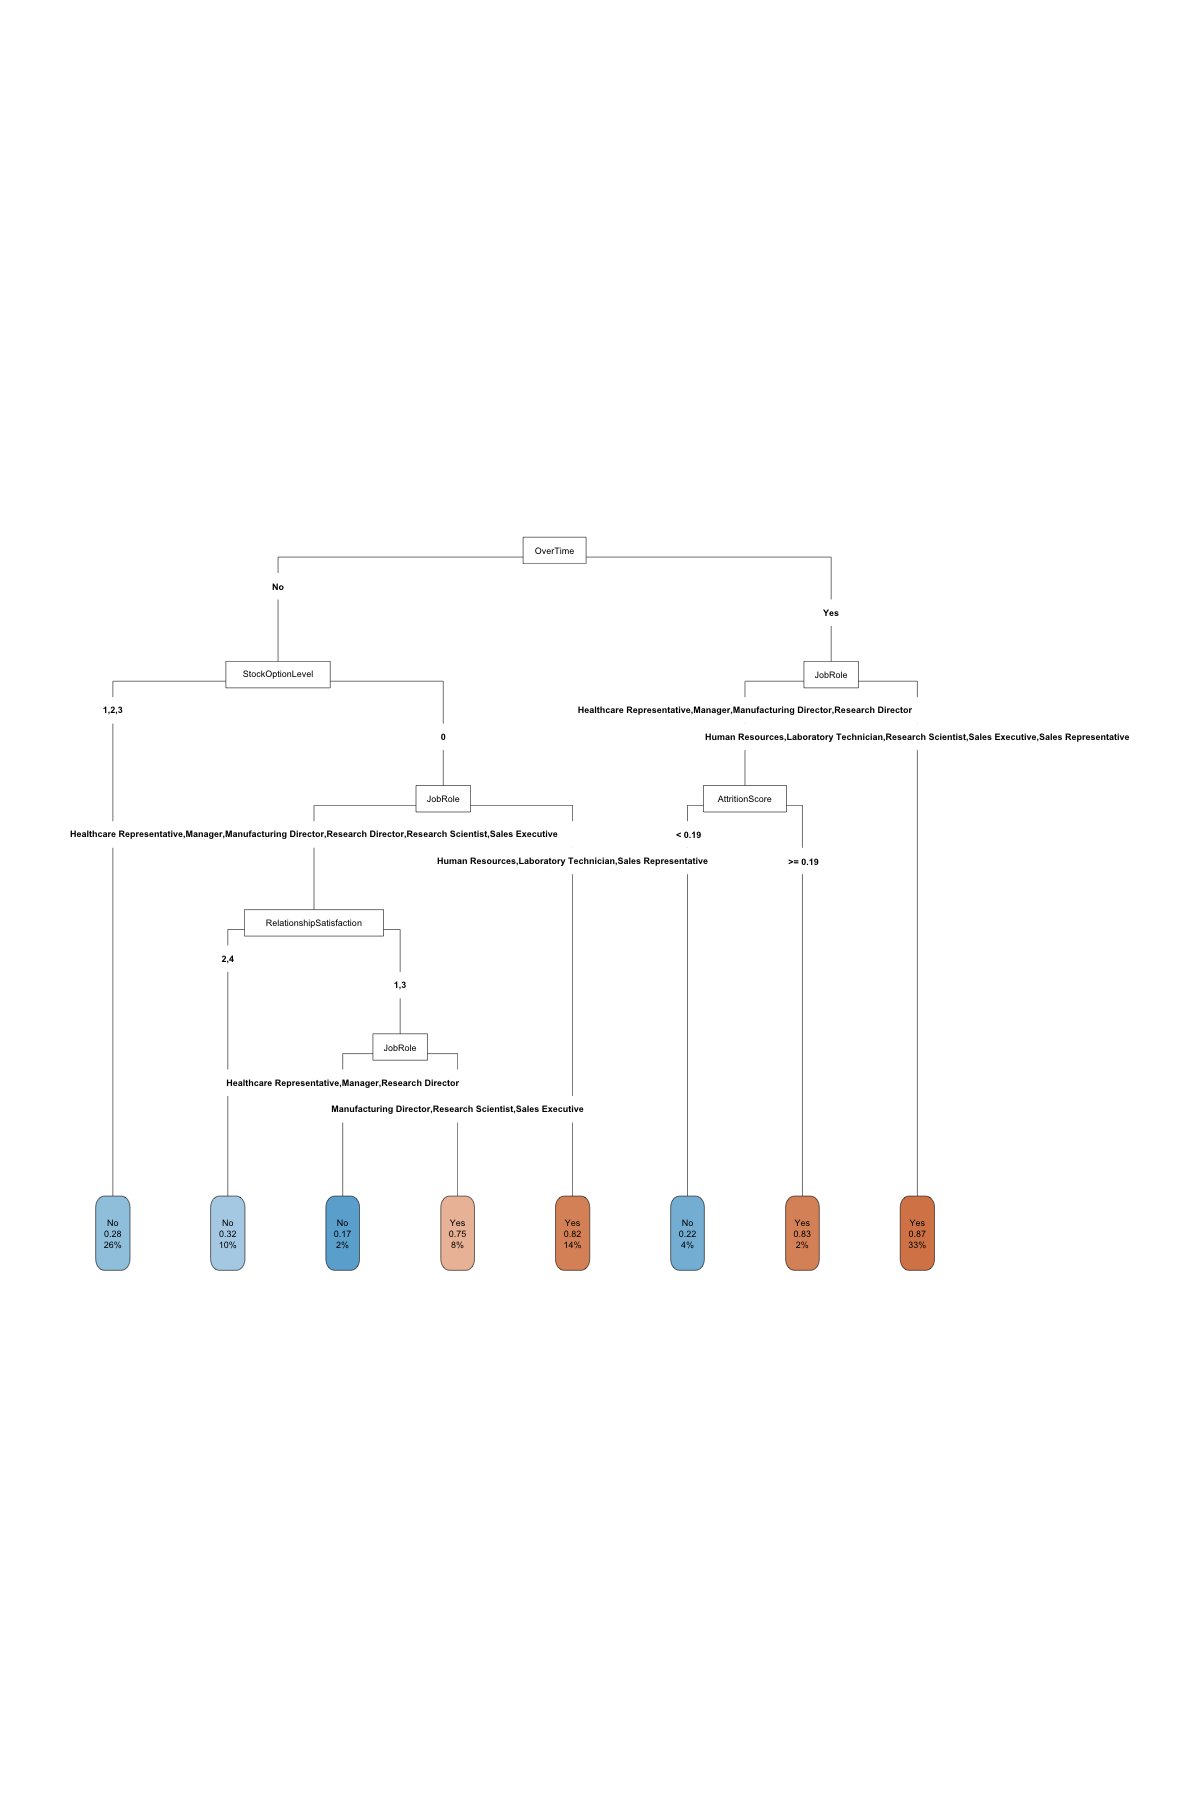

In [123]:
options(repr.plot.width=10, repr.plot.height=15) ##customize height and width of plot
rpart.plot(smote.postprune.tree, roundint = FALSE, #plot tree using rpart.plot library
box.palette = "BuBn",
type = 5)

In [124]:
#predict model using test set
smote.postprune.preds <- predict(smote.postprune.tree, test, type="class")

In [125]:
#store table of predicted and actual values
smote.cm.postprunetree <- table(test$Attrition, smote.postprune.preds)

In [126]:
#apply accuracy formula on table
smote.postprunetree.baseaccuracy <- model.accuracy(smote.cm.postprunetree )

In [127]:
#apply recall formula on yes cases of attrtiion
smote.postprunetree.baserecallYes <- AttritionYes.recall(smote.cm.postprunetree)

In [128]:
#apply precision formula on yes cases of attrtiion
smote.postprunetree.baseprecisionYes <- AttritionYes.precision(smote.cm.postprunetree)

In [129]:
#calculate F1 Score for yes cases of attrtiion
smote.postprunetree.base_F1ScoreYes <- round((2 * smote.postprunetree.baseprecisionYes * smote.postprunetree.baserecallYes) / (smote.postprunetree.baserecallYes
                                                                    +smote.postprunetree.baseprecisionYes) ,digits=2)

In [130]:
smote.postprunetree.baserecallNo <- AttritionNo.recall(smote.cm.postprunetree) #apply recall formula on no cases of attrtiion
smote.postprunetree.baseprecisionNo <- AttritionNo.precision(smote.cm.postprunetree) #apply precision formula on no cases of attrtiion


In [131]:
#calculate F1 Score for no cases of attrtiion
smote.postprunetree.base_F1ScoreNo <- round((2 * smote.postprunetree.baseprecisionNo * smote.postprunetree.baserecallNo) / (smote.postprunetree.baserecallNo
                                                                    +smote.postprunetree.baseprecisionNo) ,digits=2)

In [132]:
total.recall.smote.postprunetree <- total.recall(smote.cm.postprunetree) #apply total recall formula (both cases of attrtiion)
total.precision.smote.postprunetree <- total.precision(smote.cm.postprunetree) #apply total precision formula (both cases of attrtiion)
total.F1Score.smote.postprunetree<- round((smote.postprunetree.base_F1ScoreYes + 
                                           smote.postprunetree.base_F1ScoreNo)/2,digits=2) #calculate total F1 score (both cases of attrtiion)

## Base XGBOOST

In [133]:
base.train <- train #assign train data to  a new variable base.train
base.test <-  df[inds$test, ]  #assign test data to  a new variable base.train

In [134]:
setDT(base.train)  # Set base.train to a data table
setDT(base.test)   # Set base.test to a data table


In [135]:
base.train_label <- base.train$Attrition # assign target label for train set to a new field base.train_label
base.test_label <- base.test$Attrition   # assign target label for test set to a new field base.train_label

In [136]:
base.new_train <- model.matrix(~.+0,data = base.train[,-c("Attrition"),with=F]) # convert base.train to matrix format and assign to new variable base.new_train
base.new_test <- model.matrix(~.+0,data = base.test[,-c("Attrition"),with=F]) # convert base.test to matrix format and assign to new variable base.new_test

In [137]:
base.train_label <- as.numeric(base.train_label)-1 #convert base.train_label to numeric - 1 so we have (0,1) instead of(1,2)
base.test_label <- as.numeric(base.test_label)-1   #convert base.test_label label to numeric - 1 so we have (0,1) instead of(1,2)

In [138]:
base.dtrain <- xgb.DMatrix(data = base.new_train,label = base.train_label )  #Construct xgb.DMatrix object and assign to base.dtrain
base.dtest <- xgb.DMatrix(data = base.new_test,label = base.test_label)      #Construct xgb.DMatrix object and assign to base.dtest

In [139]:
#Train base xgb model with no hyperparameter tuning/cross validation
base.xgb <- xgb.train (data = base.dtrain, nrounds = 79, watchlist = list(val=base.dtest,train=base.dtrain), print_every_n = 10,
                   early_stopping_rounds = 10, maximize = F , eval_metric = "error")

[1]	val-error:0.149321	train-error:0.087549 
Multiple eval metrics are present. Will use train_error for early stopping.
Will train until train_error hasn't improved in 10 rounds.

[11]	val-error:0.135747	train-error:0.025292 
[21]	val-error:0.135747	train-error:0.007782 
[31]	val-error:0.128959	train-error:0.001946 
[41]	val-error:0.133484	train-error:0.000000 
Stopping. Best iteration:
[35]	val-error:0.128959	train-error:0.000000



In [140]:
base.xgbpred <- predict (base.xgb,base.dtest) #predict model using test set
base.xgbpred <- ifelse(base.xgbpred > 0.5,1,0)#if probablity > 0.5 set prediction to class 1 else set predictionto class 0

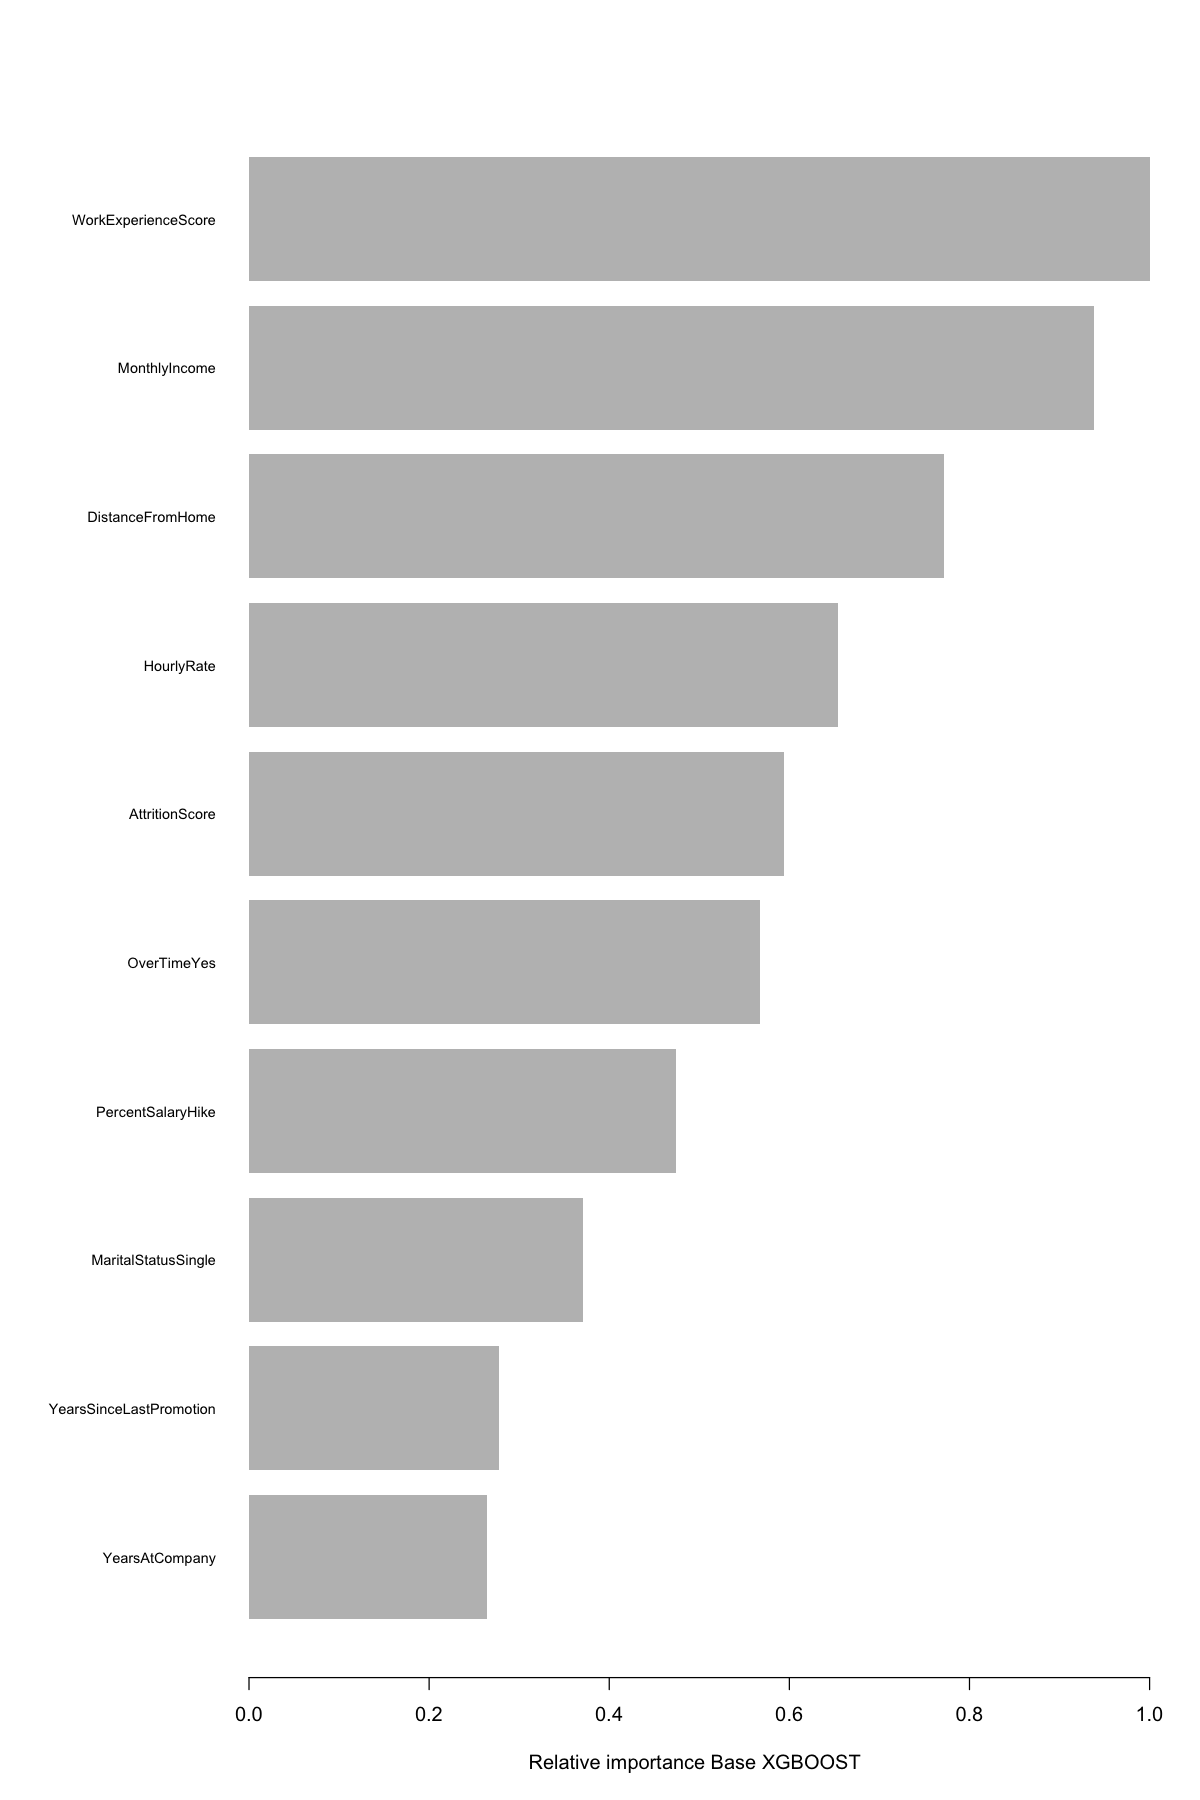

In [141]:
#Feature importance plot for base xgboost model
base.mat <- xgb.importance (feature_names = colnames(base.new_train),model = base.xgb)
xgb.plot.importance (importance_matrix = base.mat[1:10] , rel_to_first = TRUE, xlab = "Relative importance Base XGBOOST"  ) 

In [142]:
base.test$Attrition <- as.numeric(base.test$Attrition)-1 #convert target label to numeric - 1 so we have (0,1) instead of(1,2)

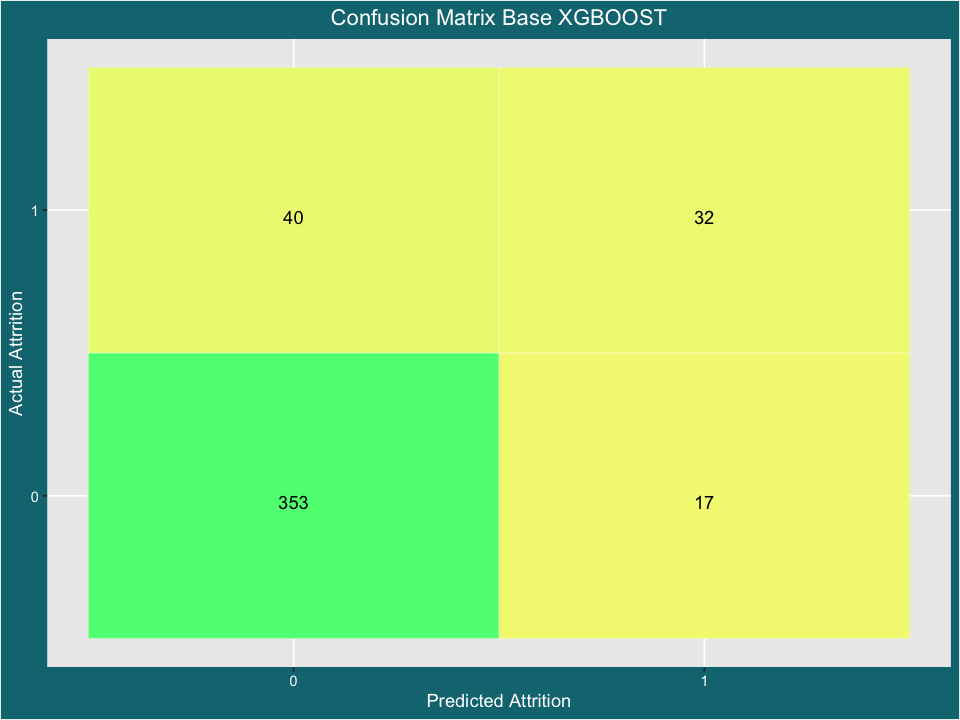

In [143]:
#customize height and width of plot
options(repr.plot.width=8, repr.plot.height=6) 
 
#store table of predicted and actual values as conf_df
conf_df <- data.frame(table(base.test$Attrition, base.xgbpred))

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = base.xgbpred, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "#58FA82") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix Base XGBOOST", y="Actual Attrrition", x="Predicted Attrition")

In [144]:
#xgb.plot.tree(model=base.xgb, tree=0)

In [145]:
#xgb.plot.tree(model=base.xgb, tree=0)

In [146]:
#store table of predicted and actual values
cm.basexgboost <- table(base.test$Attrition, base.xgbpred)

In [147]:
#apply accuracy formula on table
xgboost.baseaccuracy <- model.accuracy(cm.basexgboost)

In [148]:
#apply recall formula on yes cases of attrtiion
xgboost.baserecallYes <- AttritionYes.recall(cm.basexgboost)

In [149]:
#apply precision formula on yes cases of attrtiion
xgboost.baseprecisionYes <- AttritionYes.precision(cm.basexgboost)

In [150]:
#calculate F1 Score for yes cases of attrtiion
xgboost.base_F1ScoreYes <- round((2 * xgboost.baseprecisionYes * xgboost.baserecallYes) / (xgboost.baserecallYes
                                                                                    +xgboost.baseprecisionYes) ,digits=2)

In [151]:
xgboost.baserecallNo <- AttritionNo.recall(cm.basexgboost) #apply recall formula on no cases of attrtiion
xgboost.baseprecisionNo <- AttritionNo.precision(cm.basexgboost) #apply precision formula on no cases of attrtiion


In [152]:
#calculate F1 Score for no cases of attrtiion
xgboost.base_F1ScoreNo <- round((2 * xgboost.baseprecisionNo * xgboost.baserecallNo) / (xgboost.baserecallNo
                                                                                    +xgboost.baseprecisionNo) ,digits=2)

In [153]:
total.recall.base_XGBoost<- total.recall(cm.basexgboost) #apply total recall formula (both cases of attrtiion)
total.precision.base_XGBoost <- total.precision(cm.basexgboost) #apply total precision formula (both cases of attrtiion)
total.F1Score.base_XGBoost<- round((xgboost.base_F1ScoreYes + xgboost.base_F1ScoreNo)/2,digits=2) #calculate total F1 score (both cases of attrtiion)

##  Smote Base XGBOOST

In [154]:
smoteXgboost.train <- train_smote #assign train data to  a new variable smoteXgboost.train
smoteXgboost.test <- df[inds$test, ] #assign test data to  a new variable smoteXgboost.test

In [155]:
setDT(smoteXgboost.train) # Set smoteXgboost.train to a data table
setDT(smoteXgboost.test)  # Set smoteXgboost.test to a data table


In [156]:
smote.base.train_label <- smoteXgboost.train$Attrition # assign target label for train set to a new field smote.base.train_label
smote.base.test_label <- smoteXgboost.test $Attrition  # assign target label for test set to a new field smote.base.test_label

In [157]:
smote.base.new_train <- model.matrix(~.+0,data = smoteXgboost.train[,-c("Attrition"),with=F]) # convert base.train to matrix format and assign to new variable smote.base.new_train
smote.base.new_test <- model.matrix(~.+0,data = smoteXgboost.test[,-c("Attrition"),with=F]) # convert base.test to matrix format and assign to new variable smote.base.new_test

In [158]:
smote.base.train_label <- as.numeric(smote.base.train_label)-1 #convert smote.base.train_label to numeric - 1 so we have (0,1) instead of(1,2)
smote.base.test_label <- as.numeric(smote.base.test_label)-1   #convert smote.base.test_label to numeric - 1 so we have (0,1) instead of(1,2)

In [159]:
smote.base.dtrain <- xgb.DMatrix(data = smote.base.new_train,label = smote.base.train_label )  #Construct xgb.DMatrix object and assign to smote.base.dtrain
smote.base.dtest <- xgb.DMatrix(data = smote.base.new_test,label = smote.base.test_label)      #Construct xgb.DMatrix object and assign to smote.base.dtest

In [160]:
#Train oversampled xgb model with no hyperparameter tuning/cross validation
smote.base.xgb <- xgb.train (data = smote.base.dtrain, nrounds = 79, watchlist = list(val=smote.base.dtest,train=smote.base.dtrain), print_every_n = 10,
                   early_stopping_rounds = 10, maximize = F , eval_metric = "error")

[1]	val-error:0.418552	train-error:0.146667 
Multiple eval metrics are present. Will use train_error for early stopping.
Will train until train_error hasn't improved in 10 rounds.

[11]	val-error:0.332579	train-error:0.002424 
[21]	val-error:0.332579	train-error:0.000000 
Stopping. Best iteration:
[16]	val-error:0.334842	train-error:0.000000



In [161]:
smote.base.xgbpred <- predict (smote.base.xgb,smote.base.dtest) #predict model using test set
smote.base.xgbpred <- ifelse(smote.base.xgbpred > 0.5,1,0) #if probablity > 0.5 set prediction to class 1 else set predictionto class 0

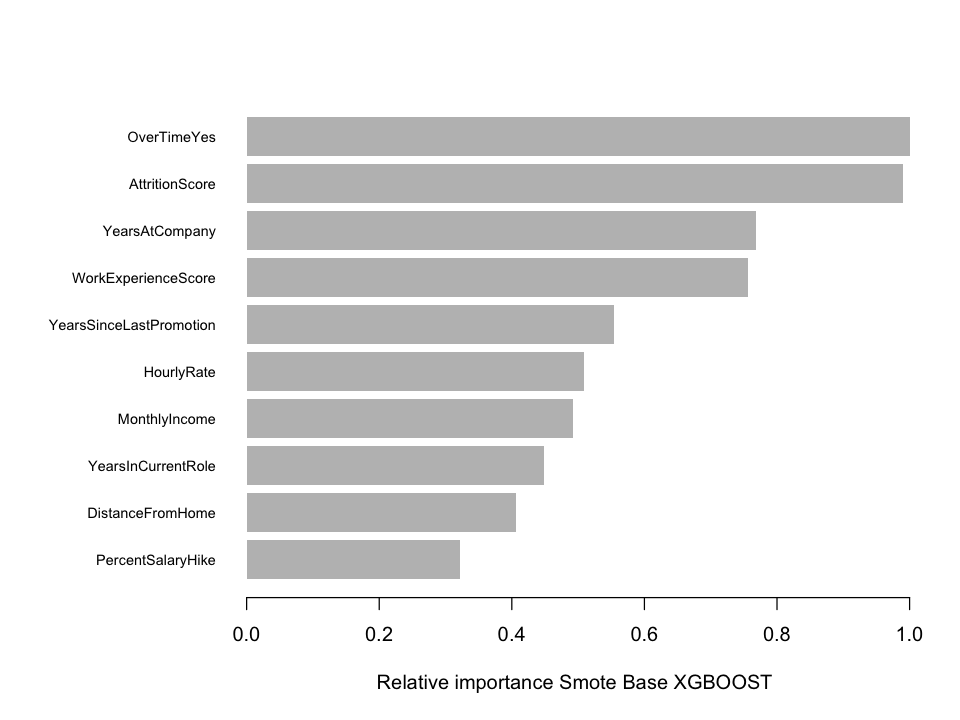

In [162]:
#Feature importance plot for base xgboost model
smote.base.mat <- xgb.importance (feature_names = colnames(smote.base.new_train),model = smote.base.xgb)
xgb.plot.importance (importance_matrix = smote.base.mat[1:10] , rel_to_first = TRUE, xlab = "Relative importance Smote Base XGBOOST"  ) 

In [163]:
smoteXgboost.test$Attrition <- as.numeric(smoteXgboost.test$Attrition)-1 #convert target label to numeric - 1 so we have (0,1) instead of(1,2)

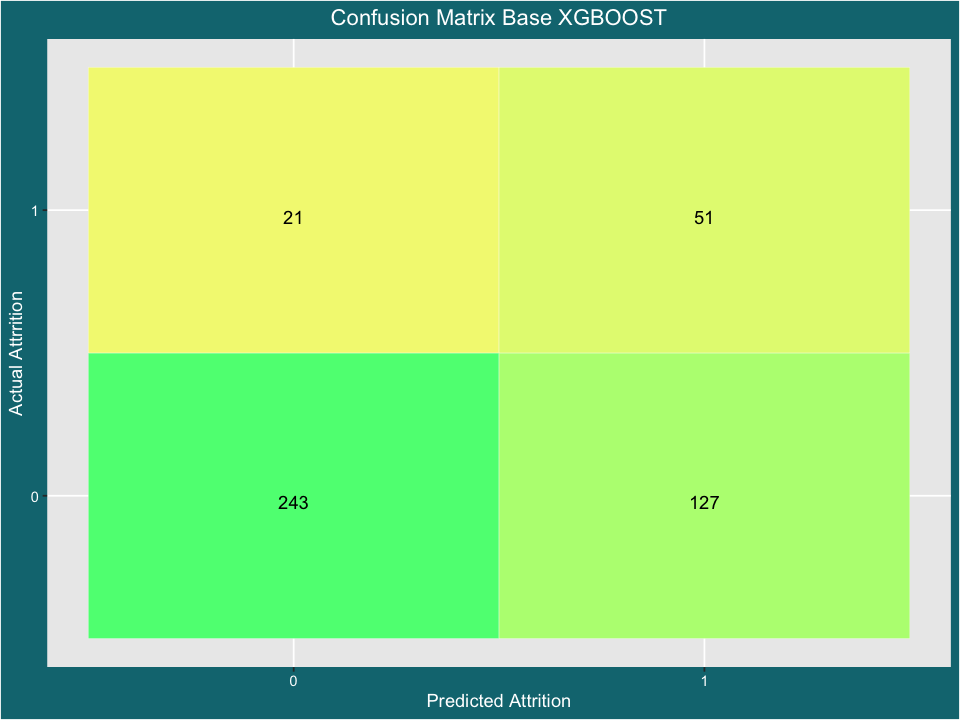

In [164]:
#customize height and width of plot
options(repr.plot.width=8, repr.plot.height=6) 
 
conf_df <- data.frame(table(smoteXgboost.test$Attrition, smote.base.xgbpred))

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = smote.base.xgbpred, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "#58FA82") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix Base XGBOOST", y="Actual Attrrition", x="Predicted Attrition")

In [165]:
#xgb.plot.tree(model=smote.base.xgb, tree=0)

In [166]:
#xgb.plot.tree(model=smote.base.xgb, tree=1)

In [167]:
#store table of predicted and actual values
cm.smote.basexgboost <- table(smoteXgboost.test$Attrition, smote.base.xgbpred)

In [168]:
#apply accuracy formula on table
smote.xgboost.baseaccuracy <- model.accuracy(cm.smote.basexgboost)

In [169]:
#apply recall formula on yes cases of attrtiion
smote.xgboost.baserecallYes <- AttritionYes.recall(cm.smote.basexgboost)

In [170]:
#apply precision formula on yes cases of attrtiion
smote.xgboost.baseprecisionYes <- AttritionYes.precision(cm.smote.basexgboost)

In [171]:
#calculate F1 Score for yes cases of attrtiion
smote.xgboost.base_F1ScoreYes <- round((2 * smote.xgboost.baseprecisionYes * smote.xgboost.baserecallYes) / (smote.xgboost.baserecallYes
                                                                                    +smote.xgboost.baseprecisionYes) ,digits=2)

In [172]:
smote.xgboost.baserecallNo <- AttritionNo.recall(cm.smote.basexgboost)#apply recall formula on no cases of attrtiion
smote.xgboost.baseprecisionNo <- AttritionNo.precision(cm.smote.basexgboost) #apply precision formula on no cases of attrtiion

In [173]:
#calculate F1 Score for no cases of attrtiion
smote.xgboost.base_F1ScoreNo <- round((2 * smote.xgboost.baseprecisionNo * smote.xgboost.baserecallNo) / (smote.xgboost.baserecallNo
                                                                                    +smote.xgboost.baseprecisionNo) ,digits=2)

In [174]:
total.recall.smote.base_XGBoost<- total.recall(cm.smote.basexgboost) #apply total recall formula (both cases of attrtiion)
total.precision.smote.base_XGBoost <- total.precision(cm.smote.basexgboost) #apply total precision formula (both cases of attrtiion)
total.F1Score.smote.base_XGBoost<- round((smote.xgboost.base_F1ScoreYes + smote.xgboost.base_F1ScoreNo)/2,digits=2) #calculate total F1 score (both cases of attrtiion)

## HyperTuned XGBOOST

In [175]:
#train test splits using partition function (70 percent train , 30 percent test)
tuned.inds <- partition(df$Attrition, p = c(train = 0.7,test = 0.3))
tuned.train <- df[tuned.inds$train, ]
tuned.test <- df[tuned.inds$test, ]


In [176]:
fact_col <- colnames(tuned.train)[sapply(tuned.train,is.character)] # check for charactar columns and store them in fact_col variable

for(i in fact_col) set(tuned.train,j=i,value = factor(tuned.train[[i]])) # convert training data to factor
for (i in fact_col) set(tuned.test,j=i,value = factor(tuned.test[[i]])) # convert test data to factor


tuned.traintask <- makeClassifTask (data = tuned.train,target = "Attrition") #create classification task for train set
tuned.testtask <- makeClassifTask (data = tuned.test,target = "Attrition")   #create classification task for test set

#one hot encoding train and test classification tasks
tuned.traintask <- createDummyFeatures (obj = tuned.traintask ) 
tuned.testtask <- createDummyFeatures (obj = tuned.testtask )

In [177]:
#create learner to be used for model training
lrn <- makeLearner("classif.xgboost",predict.type = "response")
#Specify parameter values for the learner previously defined
lrn$par.vals <- list( objective="binary:logistic", eval_metric="error", nrounds=100L, eta=0.1)

#Set parameters to be used for hyperparameter tuning
params <- makeParamSet(makeIntegerParam("max_depth",lower = 3L,upper = 10L), makeNumericParam("min_child_weight",lower = 1L,upper = 10L), makeNumericParam("subsample",lower = 0.5,upper = 1), makeNumericParam("colsample_bytree",lower = 0.5,upper = 1))

#set resampling strategy to 5 fold cross validation . Set stratify = True
rdesc <- makeResampleDesc("CV",stratify = T,iters=5L)

In [178]:
ctrl <- makeTuneControlRandom(maxit = 10L) #Set number of iterations for random search to a maximum of 10

In [179]:
#train xgboost boost model
mytune <- tuneParams(learner = lrn, task = tuned.traintask, resampling = rdesc, measures = acc, par.set = params, control = ctrl, show.info = T)

[Tune] Started tuning learner classif.xgboost for parameter set:

                    Type len Def   Constr Req Tunable Trafo
max_depth        integer   -   -  3 to 10   -    TRUE     -
min_child_weight numeric   -   -  1 to 10   -    TRUE     -
subsample        numeric   -   - 0.5 to 1   -    TRUE     -
colsample_bytree numeric   -   - 0.5 to 1   -    TRUE     -

With control class: TuneControlRandom

Imputation value: -0

[Tune-x] 1: max_depth=6; min_child_weight=4.51; subsample=0.522; colsample_bytree=0.669



[1]	train-error:0.156934 
[2]	train-error:0.142336 
[3]	train-error:0.139903 
[4]	train-error:0.139903 
[5]	train-error:0.138686 
[6]	train-error:0.137470 
[7]	train-error:0.139903 
[8]	train-error:0.141119 
[9]	train-error:0.141119 
[10]	train-error:0.139903 
[11]	train-error:0.142336 
[12]	train-error:0.138686 
[13]	train-error:0.141119 
[14]	train-error:0.142336 
[15]	train-error:0.138686 
[16]	train-error:0.139903 
[17]	train-error:0.138686 
[18]	train-error:0.136253 
[19]	train-error:0.133820 
[20]	train-error:0.135036 
[21]	train-error:0.133820 
[22]	train-error:0.131387 
[23]	train-error:0.130170 
[24]	train-error:0.128954 
[25]	train-error:0.128954 
[26]	train-error:0.125304 
[27]	train-error:0.121655 
[28]	train-error:0.125304 
[29]	train-error:0.119221 
[30]	train-error:0.120438 
[31]	train-error:0.115572 
[32]	train-error:0.114355 
[33]	train-error:0.108273 
[34]	train-error:0.109489 
[35]	train-error:0.109489 
[36]	train-error:0.107056 
[37]	train-error:0.105839 
[38]	train

[Tune-y] 1: acc.test.mean=0.8754914; time: 0.0 min

[Tune-x] 2: max_depth=8; min_child_weight=4.71; subsample=0.85; colsample_bytree=0.723



[1]	train-error:0.137470 
[2]	train-error:0.136253 
[3]	train-error:0.131387 
[4]	train-error:0.127737 
[5]	train-error:0.119221 
[6]	train-error:0.120438 
[7]	train-error:0.116788 
[8]	train-error:0.113139 
[9]	train-error:0.113139 
[10]	train-error:0.109489 
[11]	train-error:0.110706 
[12]	train-error:0.110706 
[13]	train-error:0.108273 
[14]	train-error:0.108273 
[15]	train-error:0.107056 
[16]	train-error:0.108273 
[17]	train-error:0.107056 
[18]	train-error:0.105839 
[19]	train-error:0.105839 
[20]	train-error:0.102190 
[21]	train-error:0.100973 
[22]	train-error:0.100973 
[23]	train-error:0.096107 
[24]	train-error:0.093674 
[25]	train-error:0.096107 
[26]	train-error:0.096107 
[27]	train-error:0.093674 
[28]	train-error:0.094891 
[29]	train-error:0.090024 
[30]	train-error:0.090024 
[31]	train-error:0.088808 
[32]	train-error:0.086375 
[33]	train-error:0.086375 
[34]	train-error:0.082725 
[35]	train-error:0.079075 
[36]	train-error:0.081509 
[37]	train-error:0.079075 
[38]	train

[Tune-y] 2: acc.test.mean=0.8657637; time: 0.0 min

[Tune-x] 3: max_depth=3; min_child_weight=5.66; subsample=0.752; colsample_bytree=0.959



[1]	train-error:0.150852 
[2]	train-error:0.139903 
[3]	train-error:0.135036 
[4]	train-error:0.135036 
[5]	train-error:0.131387 
[6]	train-error:0.132603 
[7]	train-error:0.131387 
[8]	train-error:0.135036 
[9]	train-error:0.138686 
[10]	train-error:0.138686 
[11]	train-error:0.136253 
[12]	train-error:0.137470 
[13]	train-error:0.135036 
[14]	train-error:0.130170 
[15]	train-error:0.128954 
[16]	train-error:0.128954 
[17]	train-error:0.126521 
[18]	train-error:0.124088 
[19]	train-error:0.124088 
[20]	train-error:0.124088 
[21]	train-error:0.124088 
[22]	train-error:0.120438 
[23]	train-error:0.116788 
[24]	train-error:0.118005 
[25]	train-error:0.116788 
[26]	train-error:0.115572 
[27]	train-error:0.116788 
[28]	train-error:0.114355 
[29]	train-error:0.113139 
[30]	train-error:0.111922 
[31]	train-error:0.111922 
[32]	train-error:0.110706 
[33]	train-error:0.110706 
[34]	train-error:0.108273 
[35]	train-error:0.109489 
[36]	train-error:0.107056 
[37]	train-error:0.108273 
[38]	train

[Tune-y] 3: acc.test.mean=0.8725598; time: 0.0 min

[Tune-x] 4: max_depth=6; min_child_weight=3.5; subsample=0.914; colsample_bytree=0.725



[1]	train-error:0.131387 
[2]	train-error:0.121655 
[3]	train-error:0.122871 
[4]	train-error:0.111922 
[5]	train-error:0.110706 
[6]	train-error:0.108273 
[7]	train-error:0.103406 
[8]	train-error:0.100973 
[9]	train-error:0.099757 
[10]	train-error:0.102190 
[11]	train-error:0.103406 
[12]	train-error:0.098540 
[13]	train-error:0.094891 
[14]	train-error:0.098540 
[15]	train-error:0.096107 
[16]	train-error:0.094891 
[17]	train-error:0.092457 
[18]	train-error:0.093674 
[19]	train-error:0.092457 
[20]	train-error:0.092457 
[21]	train-error:0.091241 
[22]	train-error:0.087591 
[23]	train-error:0.090024 
[24]	train-error:0.087591 
[25]	train-error:0.083942 
[26]	train-error:0.079075 
[27]	train-error:0.077859 
[28]	train-error:0.081509 
[29]	train-error:0.075426 
[30]	train-error:0.075426 
[31]	train-error:0.075426 
[32]	train-error:0.074209 
[33]	train-error:0.071776 
[34]	train-error:0.070560 
[35]	train-error:0.069343 
[36]	train-error:0.065693 
[37]	train-error:0.066910 
[38]	train

[Tune-y] 4: acc.test.mean=0.8706086; time: 0.0 min

[Tune-x] 5: max_depth=5; min_child_weight=4.61; subsample=0.644; colsample_bytree=0.74



[1]	train-error:0.143552 
[2]	train-error:0.145985 
[3]	train-error:0.143552 
[4]	train-error:0.141119 
[5]	train-error:0.139903 
[6]	train-error:0.133820 
[7]	train-error:0.130170 
[8]	train-error:0.133820 
[9]	train-error:0.131387 
[10]	train-error:0.132603 
[11]	train-error:0.126521 
[12]	train-error:0.124088 
[13]	train-error:0.127737 
[14]	train-error:0.125304 
[15]	train-error:0.120438 
[16]	train-error:0.121655 
[17]	train-error:0.122871 
[18]	train-error:0.120438 
[19]	train-error:0.118005 
[20]	train-error:0.121655 
[21]	train-error:0.120438 
[22]	train-error:0.115572 
[23]	train-error:0.115572 
[24]	train-error:0.113139 
[25]	train-error:0.113139 
[26]	train-error:0.111922 
[27]	train-error:0.109489 
[28]	train-error:0.108273 
[29]	train-error:0.108273 
[30]	train-error:0.107056 
[31]	train-error:0.110706 
[32]	train-error:0.109489 
[33]	train-error:0.107056 
[34]	train-error:0.105839 
[35]	train-error:0.105839 
[36]	train-error:0.103406 
[37]	train-error:0.099757 
[38]	train

[Tune-y] 5: acc.test.mean=0.8754914; time: 0.0 min

[Tune-x] 6: max_depth=3; min_child_weight=5.71; subsample=0.631; colsample_bytree=0.766



[1]	train-error:0.171533 
[2]	train-error:0.148418 
[3]	train-error:0.148418 
[4]	train-error:0.148418 
[5]	train-error:0.148418 
[6]	train-error:0.148418 
[7]	train-error:0.148418 
[8]	train-error:0.141119 
[9]	train-error:0.138686 
[10]	train-error:0.143552 
[11]	train-error:0.139903 
[12]	train-error:0.141119 
[13]	train-error:0.143552 
[14]	train-error:0.141119 
[15]	train-error:0.139903 
[16]	train-error:0.135036 
[17]	train-error:0.130170 
[18]	train-error:0.131387 
[19]	train-error:0.131387 
[20]	train-error:0.132603 
[21]	train-error:0.131387 
[22]	train-error:0.130170 
[23]	train-error:0.130170 
[24]	train-error:0.128954 
[25]	train-error:0.128954 
[26]	train-error:0.125304 
[27]	train-error:0.121655 
[28]	train-error:0.124088 
[29]	train-error:0.120438 
[30]	train-error:0.120438 
[31]	train-error:0.116788 
[32]	train-error:0.114355 
[33]	train-error:0.115572 
[34]	train-error:0.111922 
[35]	train-error:0.113139 
[36]	train-error:0.109489 
[37]	train-error:0.114355 
[38]	train

[Tune-y] 6: acc.test.mean=0.8686621; time: 0.0 min

[Tune-x] 7: max_depth=10; min_child_weight=3.05; subsample=0.955; colsample_bytree=0.829



[1]	train-error:0.124088 
[2]	train-error:0.114355 
[3]	train-error:0.111922 
[4]	train-error:0.104623 
[5]	train-error:0.100973 
[6]	train-error:0.098540 
[7]	train-error:0.094891 
[8]	train-error:0.098540 
[9]	train-error:0.096107 
[10]	train-error:0.091241 
[11]	train-error:0.092457 
[12]	train-error:0.087591 
[13]	train-error:0.086375 
[14]	train-error:0.085158 
[15]	train-error:0.080292 
[16]	train-error:0.077859 
[17]	train-error:0.077859 
[18]	train-error:0.077859 
[19]	train-error:0.075426 
[20]	train-error:0.075426 
[21]	train-error:0.071776 
[22]	train-error:0.069343 
[23]	train-error:0.068127 
[24]	train-error:0.069343 
[25]	train-error:0.065693 
[26]	train-error:0.064477 
[27]	train-error:0.065693 
[28]	train-error:0.064477 
[29]	train-error:0.063260 
[30]	train-error:0.062044 
[31]	train-error:0.059611 
[32]	train-error:0.055961 
[33]	train-error:0.054745 
[34]	train-error:0.055961 
[35]	train-error:0.054745 
[36]	train-error:0.052311 
[37]	train-error:0.049878 
[38]	train

[Tune-y] 7: acc.test.mean=0.8725503; time: 0.0 min

[Tune-x] 8: max_depth=7; min_child_weight=3.89; subsample=0.823; colsample_bytree=0.835



[1]	train-error:0.135036 
[2]	train-error:0.125304 
[3]	train-error:0.120438 
[4]	train-error:0.118005 
[5]	train-error:0.111922 
[6]	train-error:0.116788 
[7]	train-error:0.110706 
[8]	train-error:0.114355 
[9]	train-error:0.114355 
[10]	train-error:0.114355 
[11]	train-error:0.108273 
[12]	train-error:0.105839 
[13]	train-error:0.104623 
[14]	train-error:0.107056 
[15]	train-error:0.105839 
[16]	train-error:0.102190 
[17]	train-error:0.102190 
[18]	train-error:0.102190 
[19]	train-error:0.100973 
[20]	train-error:0.102190 
[21]	train-error:0.097324 
[22]	train-error:0.093674 
[23]	train-error:0.094891 
[24]	train-error:0.096107 
[25]	train-error:0.092457 
[26]	train-error:0.088808 
[27]	train-error:0.086375 
[28]	train-error:0.086375 
[29]	train-error:0.091241 
[30]	train-error:0.085158 
[31]	train-error:0.086375 
[32]	train-error:0.082725 
[33]	train-error:0.082725 
[34]	train-error:0.083942 
[35]	train-error:0.081509 
[36]	train-error:0.081509 
[37]	train-error:0.081509 
[38]	train

[Tune-y] 8: acc.test.mean=0.8754724; time: 0.0 min

[Tune-x] 9: max_depth=6; min_child_weight=3.07; subsample=0.702; colsample_bytree=0.911



[1]	train-error:0.135036 
[2]	train-error:0.115572 
[3]	train-error:0.122871 
[4]	train-error:0.116788 
[5]	train-error:0.114355 
[6]	train-error:0.118005 
[7]	train-error:0.119221 
[8]	train-error:0.109489 
[9]	train-error:0.102190 
[10]	train-error:0.104623 
[11]	train-error:0.104623 
[12]	train-error:0.104623 
[13]	train-error:0.099757 
[14]	train-error:0.097324 
[15]	train-error:0.094891 
[16]	train-error:0.094891 
[17]	train-error:0.093674 
[18]	train-error:0.093674 
[19]	train-error:0.090024 
[20]	train-error:0.091241 
[21]	train-error:0.092457 
[22]	train-error:0.088808 
[23]	train-error:0.086375 
[24]	train-error:0.086375 
[25]	train-error:0.087591 
[26]	train-error:0.083942 
[27]	train-error:0.083942 
[28]	train-error:0.082725 
[29]	train-error:0.080292 
[30]	train-error:0.081509 
[31]	train-error:0.077859 
[32]	train-error:0.077859 
[33]	train-error:0.076642 
[34]	train-error:0.071776 
[35]	train-error:0.074209 
[36]	train-error:0.074209 
[37]	train-error:0.072993 
[38]	train

[Tune-y] 9: acc.test.mean=0.8686621; time: 0.0 min

[Tune-x] 10: max_depth=4; min_child_weight=7.54; subsample=0.913; colsample_bytree=0.586



[1]	train-error:0.144769 
[2]	train-error:0.149635 
[3]	train-error:0.148418 
[4]	train-error:0.143552 
[5]	train-error:0.143552 
[6]	train-error:0.139903 
[7]	train-error:0.141119 
[8]	train-error:0.142336 
[9]	train-error:0.136253 
[10]	train-error:0.135036 
[11]	train-error:0.138686 
[12]	train-error:0.133820 
[13]	train-error:0.130170 
[14]	train-error:0.133820 
[15]	train-error:0.130170 
[16]	train-error:0.130170 
[17]	train-error:0.125304 
[18]	train-error:0.126521 
[19]	train-error:0.127737 
[20]	train-error:0.125304 
[21]	train-error:0.124088 
[22]	train-error:0.125304 
[23]	train-error:0.116788 
[24]	train-error:0.116788 
[25]	train-error:0.115572 
[26]	train-error:0.115572 
[27]	train-error:0.115572 
[28]	train-error:0.111922 
[29]	train-error:0.110706 
[30]	train-error:0.108273 
[31]	train-error:0.104623 
[32]	train-error:0.108273 
[33]	train-error:0.107056 
[34]	train-error:0.109489 
[35]	train-error:0.107056 
[36]	train-error:0.108273 
[37]	train-error:0.103406 
[38]	train

[Tune-y] 10: acc.test.mean=0.8715794; time: 0.0 min

[Tune] Result: max_depth=6; min_child_weight=4.51; subsample=0.522; colsample_bytree=0.669 : acc.test.mean=0.8754914



In [180]:
setDT(tuned.train)  #set train set to data table
setDT(tuned.test)   #set test set to data table


In [181]:
tuned.train_label <- tuned.train$Attrition  # assign target label for train set to a new field tuned.train_label
tuned.test_label <- tuned.test$Attrition     # assign target label for test set to a new field tuned.test_label

In [182]:
tuned.new_train <- model.matrix(~.+0,data = tuned.train[,-c("Attrition"),with=F]) # convert tuned.train to matrix format and assign to new variable tuned.new_train
tuned.new_test <- model.matrix(~.+0,data = tuned.test[,-c("Attrition"),with=F])    # convert tuned.test to matrix format and assign to new variable tuned.new_test

In [183]:
tuned.train_label <- as.numeric(tuned.train_label)-1 #convert tuned.train_label to numeric - 1 so we have (0,1) instead of(1,2)
tuned.test_label <- as.numeric(tuned.test_label)-1   #convert tuned.test_label to numeric - 1 so we have (0,1) instead of(1,2)

In [184]:
tuned.dtrain <- xgb.DMatrix(data = tuned.new_train,label = tuned.train_label )  #Construct xgb.DMatrix object from train set and assign to tuned.dtrain
tuned.dtest <- xgb.DMatrix(data = tuned.new_test,label = tuned.test_label) #Construct xgb.DMatrix object from test set and assign to tuned.dtest

In [185]:
#assign parameters based on best paramaters from hypertune/cross validation
params <- list(booster = 'gbtree', objective = "binary:logistic", 
               eta=0.3, gamma=0, max_depth= mytune$x$max_depth, 
               min_child_weight=mytune$x$min_child_weight, subsample=mytune$x$subsample,
               colsample_bytree= mytune$x$colsample_bytree)

In [186]:
#Train hypertuned xgb model  using assigned params previously defined 
tuned.xgb <- xgb.train (params = params, data = tuned.dtrain, nrounds = 79, 
                   watchlist = list(val=tuned.dtest,train=tuned.dtrain), print_every_n = 10, 
                   early_stopping_rounds = 10, maximize = F , eval_metric = "error")

[1]	val-error:0.176471	train-error:0.143969 
Multiple eval metrics are present. Will use train_error for early stopping.
Will train until train_error hasn't improved in 10 rounds.

[11]	val-error:0.174208	train-error:0.113813 
[21]	val-error:0.149321	train-error:0.091440 
[31]	val-error:0.144796	train-error:0.076848 
[41]	val-error:0.142534	train-error:0.060311 
[51]	val-error:0.135747	train-error:0.054475 
[61]	val-error:0.140271	train-error:0.042802 
[71]	val-error:0.128959	train-error:0.042802 
Stopping. Best iteration:
[63]	val-error:0.140271	train-error:0.041829



In [187]:
tuned.xgbpred <- predict (tuned.xgb,tuned.dtest) #predict model using test set

In [188]:
tuned.xgbpred <- ifelse(tuned.xgbpred > 0.5,1,0) #if probablity > 0.5 set prediction to class 1 else set prediction to class 0

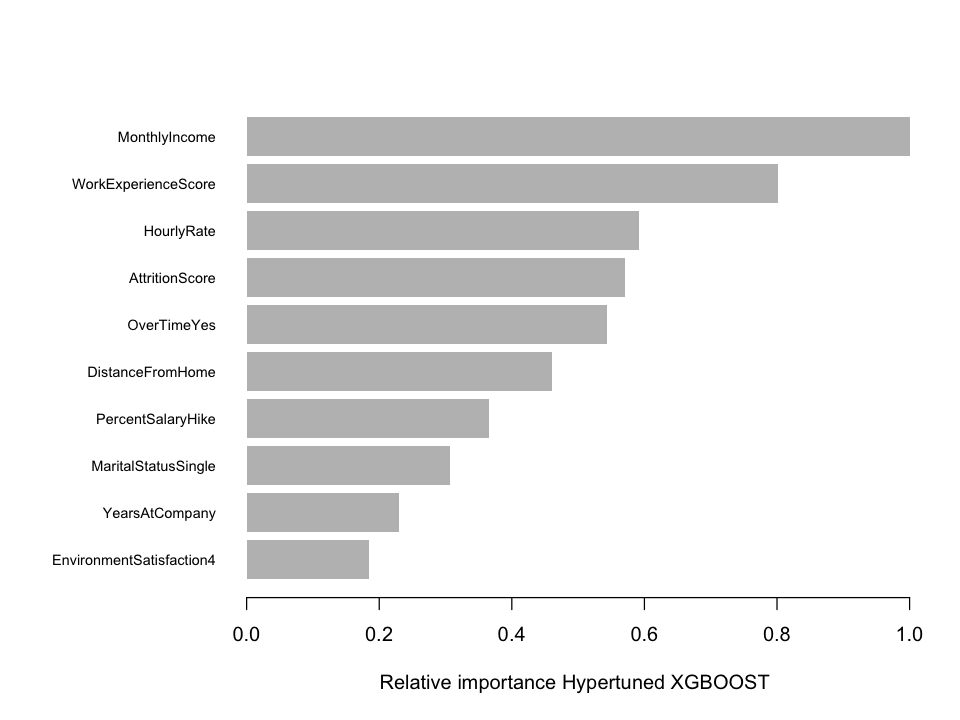

In [189]:
#Feature importance plot for base xgboost model
tuned.mat <- xgb.importance (feature_names = colnames(tuned.new_train),model = tuned.xgb)
xgb.plot.importance (importance_matrix = tuned.mat[1:10] , rel_to_first = TRUE, xlab = "Relative importance Hypertuned XGBOOST"  ) 

In [190]:
tuned.test$Attrition <- as.numeric(tuned.test$Attrition)-1 #convert target label to numeric - 1 so we have (0,1) instead of(1,2)

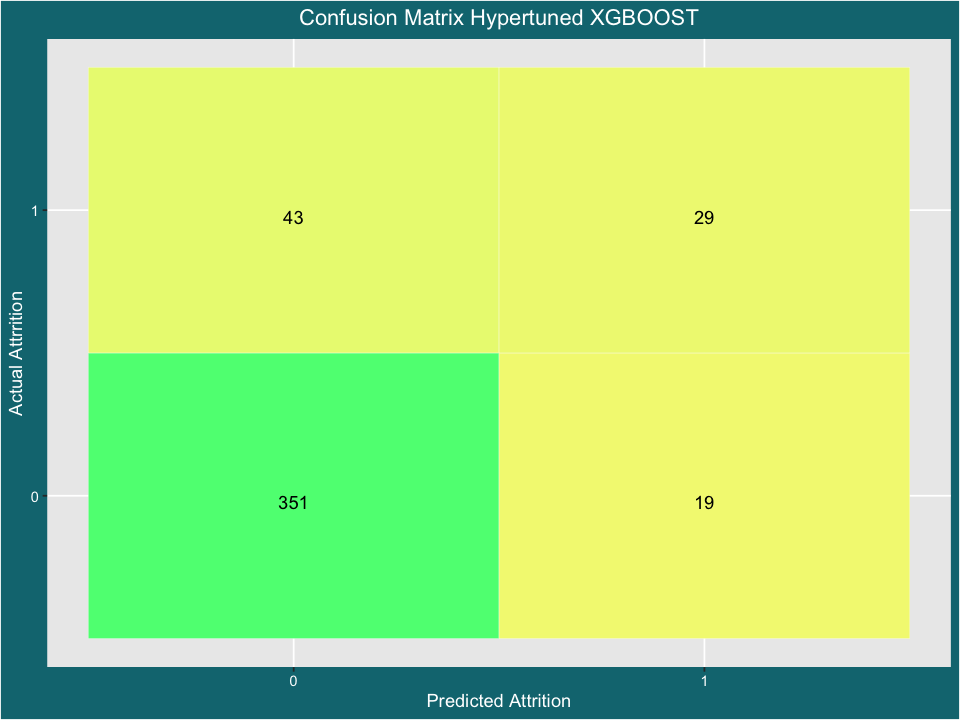

In [191]:
options(repr.plot.width=8, repr.plot.height=6) 
 
#store results table in conf_df
conf_df <- data.frame(table(tuned.test$Attrition, tuned.xgbpred))

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = tuned.xgbpred, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "#58FA82") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix Hypertuned XGBOOST", y="Actual Attrrition", x="Predicted Attrition")

In [192]:
#xgb.plot.tree(model=tuned.xgb, tree=0)

In [193]:
#xgb.plot.tree(model=tuned.xgb, tree=1)

In [194]:
#store table of predicted and actual values
tuned.cmxgboost<- table(tuned.test$Attrition, tuned.xgbpred)

In [195]:
#apply accuracy formula on table
xgboost.hypertunedaccuracy <- model.accuracy(tuned.cmxgboost)

In [196]:
#apply recall formula on yes cases of attrtiion
xgboost.hypertunedrecallYes <- AttritionYes.recall(tuned.cmxgboost)

In [197]:
#apply precision formula on yes cases of attrtiion
xgboost.hypertunedprecisionYes <- AttritionYes.precision(tuned.cmxgboost)

In [198]:
#calculate F1 Score for yes cases of attrtiion
xgboost.hypertuned_F1ScoreYes <- round((2 * xgboost.hypertunedprecisionYes * xgboost.hypertunedrecallYes) / (xgboost.hypertunedrecallYes
                                                                                    +xgboost.hypertunedprecisionYes) ,digits=2)

In [199]:
xgboost.hypertunedrecallNo <- AttritionNo.recall(tuned.cmxgboost) #apply recall formula on no cases of attrtiion
xgboost.hypertunedprecisionNo <- AttritionNo.precision(tuned.cmxgboost) #apply precision formula on no cases of attrtiion

In [200]:
#calculate F1 Score for no cases of attrtiion
xgboost.hypertuned_F1ScoreNo <- round((2 * xgboost.hypertunedprecisionNo * xgboost.hypertunedrecallNo) / (xgboost.hypertunedrecallNo
                                                                                    +xgboost.hypertunedprecisionNo) ,digits=2)

In [201]:
total.recall.hypertuned_XGBoost<- total.recall(tuned.cmxgboost) #apply total recall formula (both cases of attrtiion)
total.precision.hypertunedXGBoost <- total.precision(tuned.cmxgboost) #apply total precision formula (both cases of attrtiion)
total.F1Score.hypertunedXGBoost<- round((xgboost.hypertuned_F1ScoreYes + xgboost.hypertuned_F1ScoreNo)/2,digits=2)  #calculate total f1 score (both cases of attrtiion)

## Smote HyperTuned XGBOOST

In [202]:
smote.tuned.test <- test         # assign new variable smote.tuned.test as training set from test
smote.tuned.train <- train_smote # assign new variable smote.tuned.train as training set from train_smote

In [203]:
setDF(smote.tuned.train)  # Set smote.tuned.train to a data frame

In [204]:
smote.fact_col <- colnames(smote.tuned.train)[sapply(smote.tuned.train,is.character)] # check for charactar columns and store them in smote.fact_col variable


for(i in smote.fact_col) set(smote.tuned.train,j=i,value = factor(smote.tuned.train[[i]]))  # convert training data to factor
for (i in smote.fact_col) set(smote.tuned.test,j=i,value = factor(smote.tuned.test[[i]]))    # convert testing data to factor

#create tasks
smote.tuned.traintask <- makeClassifTask (data = smote.tuned.train,target = "Attrition")  #create classification task for train set
smote.tuned.testtask <- makeClassifTask (data = smote.tuned.test,target = "Attrition")    #create classification task for test set

#one hot encoding for train adn test classification tasks
smote.tuned.traintask <- createDummyFeatures (obj = smote.tuned.traintask ) 
smote.tuned.testtask <- createDummyFeatures (obj = smote.tuned.testtask )

In [205]:
#create learner to be used for model training
lrn <- makeLearner("classif.xgboost",predict.type = "response")
#Specify parameter values for the learner previously defined
lrn$par.vals <- list( objective="binary:logistic", eval_metric="error", nrounds=100L, eta=0.1)

#Set parameters to be used for hyperparameter tuning
params <- makeParamSet(makeIntegerParam("max_depth",lower = 3L,upper = 10L), makeNumericParam("min_child_weight",lower = 1L,upper = 10L), makeNumericParam("subsample",lower = 0.5,upper = 1), makeNumericParam("colsample_bytree",lower = 0.5,upper = 1))


rdesc <- makeResampleDesc("CV",stratify = T,iters=5L)#set resampling strategy to 5 fold cross validation . Set stratify = True
ctrl <- makeTuneControlRandom(maxit = 10L)  #Set number of iterations for random search to a maximum of 10

In [206]:
#train xgboost boost model
smotetuneXG <- tuneParams(learner = lrn, task = smote.tuned.traintask, resampling = rdesc, measures = acc, par.set = params, control = ctrl, show.info = T)

[Tune] Started tuning learner classif.xgboost for parameter set:

                    Type len Def   Constr Req Tunable Trafo
max_depth        integer   -   -  3 to 10   -    TRUE     -
min_child_weight numeric   -   -  1 to 10   -    TRUE     -
subsample        numeric   -   - 0.5 to 1   -    TRUE     -
colsample_bytree numeric   -   - 0.5 to 1   -    TRUE     -

With control class: TuneControlRandom

Imputation value: -0

[Tune-x] 1: max_depth=7; min_child_weight=1.35; subsample=0.855; colsample_bytree=0.673



[1]	train-error:0.146970 
[2]	train-error:0.104545 
[3]	train-error:0.087879 
[4]	train-error:0.084848 
[5]	train-error:0.072727 
[6]	train-error:0.066667 
[7]	train-error:0.062121 
[8]	train-error:0.050000 
[9]	train-error:0.045455 
[10]	train-error:0.040909 
[11]	train-error:0.042424 
[12]	train-error:0.034848 
[13]	train-error:0.036364 
[14]	train-error:0.034848 
[15]	train-error:0.034848 
[16]	train-error:0.030303 
[17]	train-error:0.028788 
[18]	train-error:0.028788 
[19]	train-error:0.024242 
[20]	train-error:0.021212 
[21]	train-error:0.019697 
[22]	train-error:0.019697 
[23]	train-error:0.019697 
[24]	train-error:0.018182 
[25]	train-error:0.016667 
[26]	train-error:0.015152 
[27]	train-error:0.013636 
[28]	train-error:0.012121 
[29]	train-error:0.012121 
[30]	train-error:0.007576 
[31]	train-error:0.012121 
[32]	train-error:0.007576 
[33]	train-error:0.006061 
[34]	train-error:0.004545 
[35]	train-error:0.004545 
[36]	train-error:0.001515 
[37]	train-error:0.003030 
[38]	train

[Tune-y] 1: acc.test.mean=0.8909091; time: 0.0 min

[Tune-x] 2: max_depth=8; min_child_weight=6.3; subsample=0.904; colsample_bytree=0.891



[1]	train-error:0.234848 
[2]	train-error:0.234848 
[3]	train-error:0.200000 
[4]	train-error:0.193939 
[5]	train-error:0.162121 
[6]	train-error:0.154545 
[7]	train-error:0.148485 
[8]	train-error:0.145455 
[9]	train-error:0.145455 
[10]	train-error:0.148485 
[11]	train-error:0.134848 
[12]	train-error:0.127273 
[13]	train-error:0.124242 
[14]	train-error:0.110606 
[15]	train-error:0.106061 
[16]	train-error:0.100000 
[17]	train-error:0.092424 
[18]	train-error:0.086364 
[19]	train-error:0.084848 
[20]	train-error:0.083333 
[21]	train-error:0.084848 
[22]	train-error:0.087879 
[23]	train-error:0.071212 
[24]	train-error:0.069697 
[25]	train-error:0.068182 
[26]	train-error:0.065152 
[27]	train-error:0.068182 
[28]	train-error:0.068182 
[29]	train-error:0.065152 
[30]	train-error:0.066667 
[31]	train-error:0.063636 
[32]	train-error:0.060606 
[33]	train-error:0.062121 
[34]	train-error:0.062121 
[35]	train-error:0.054545 
[36]	train-error:0.051515 
[37]	train-error:0.050000 
[38]	train

[Tune-y] 2: acc.test.mean=0.8751515; time: 0.0 min

[Tune-x] 3: max_depth=9; min_child_weight=6.85; subsample=0.993; colsample_bytree=0.96



[1]	train-error:0.222727 
[2]	train-error:0.203030 
[3]	train-error:0.187879 
[4]	train-error:0.187879 
[5]	train-error:0.174242 
[6]	train-error:0.165152 
[7]	train-error:0.154545 
[8]	train-error:0.153030 
[9]	train-error:0.151515 
[10]	train-error:0.140909 
[11]	train-error:0.131818 
[12]	train-error:0.119697 
[13]	train-error:0.121212 
[14]	train-error:0.118182 
[15]	train-error:0.116667 
[16]	train-error:0.106061 
[17]	train-error:0.100000 
[18]	train-error:0.100000 
[19]	train-error:0.084848 
[20]	train-error:0.092424 
[21]	train-error:0.087879 
[22]	train-error:0.081818 
[23]	train-error:0.080303 
[24]	train-error:0.077273 
[25]	train-error:0.074242 
[26]	train-error:0.074242 
[27]	train-error:0.069697 
[28]	train-error:0.069697 
[29]	train-error:0.072727 
[30]	train-error:0.057576 
[31]	train-error:0.053030 
[32]	train-error:0.054545 
[33]	train-error:0.048485 
[34]	train-error:0.050000 
[35]	train-error:0.050000 
[36]	train-error:0.046970 
[37]	train-error:0.045455 
[38]	train

[Tune-y] 3: acc.test.mean=0.8739394; time: 0.0 min

[Tune-x] 4: max_depth=5; min_child_weight=5.08; subsample=0.661; colsample_bytree=0.576



[1]	train-error:0.254545 
[2]	train-error:0.181818 
[3]	train-error:0.172727 
[4]	train-error:0.184848 
[5]	train-error:0.157576 
[6]	train-error:0.142424 
[7]	train-error:0.131818 
[8]	train-error:0.128788 
[9]	train-error:0.124242 
[10]	train-error:0.130303 
[11]	train-error:0.128788 
[12]	train-error:0.131818 
[13]	train-error:0.127273 
[14]	train-error:0.136364 
[15]	train-error:0.125758 
[16]	train-error:0.119697 
[17]	train-error:0.115152 
[18]	train-error:0.112121 
[19]	train-error:0.112121 
[20]	train-error:0.109091 
[21]	train-error:0.107576 
[22]	train-error:0.100000 
[23]	train-error:0.098485 
[24]	train-error:0.087879 
[25]	train-error:0.087879 
[26]	train-error:0.090909 
[27]	train-error:0.089394 
[28]	train-error:0.084848 
[29]	train-error:0.080303 
[30]	train-error:0.084848 
[31]	train-error:0.075758 
[32]	train-error:0.072727 
[33]	train-error:0.069697 
[34]	train-error:0.069697 
[35]	train-error:0.066667 
[36]	train-error:0.065152 
[37]	train-error:0.066667 
[38]	train

[Tune-y] 4: acc.test.mean=0.8727273; time: 0.0 min

[Tune-x] 5: max_depth=9; min_child_weight=1.75; subsample=0.784; colsample_bytree=0.669



[1]	train-error:0.175758 
[2]	train-error:0.140909 
[3]	train-error:0.112121 
[4]	train-error:0.109091 
[5]	train-error:0.081818 
[6]	train-error:0.068182 
[7]	train-error:0.071212 
[8]	train-error:0.059091 
[9]	train-error:0.053030 
[10]	train-error:0.046970 
[11]	train-error:0.039394 
[12]	train-error:0.040909 
[13]	train-error:0.039394 
[14]	train-error:0.033333 
[15]	train-error:0.030303 
[16]	train-error:0.027273 
[17]	train-error:0.019697 
[18]	train-error:0.021212 
[19]	train-error:0.021212 
[20]	train-error:0.013636 
[21]	train-error:0.013636 
[22]	train-error:0.012121 
[23]	train-error:0.013636 
[24]	train-error:0.010606 
[25]	train-error:0.010606 
[26]	train-error:0.012121 
[27]	train-error:0.009091 
[28]	train-error:0.010606 
[29]	train-error:0.006061 
[30]	train-error:0.006061 
[31]	train-error:0.004545 
[32]	train-error:0.006061 
[33]	train-error:0.004545 
[34]	train-error:0.004545 
[35]	train-error:0.004545 
[36]	train-error:0.004545 
[37]	train-error:0.004545 
[38]	train

[Tune-y] 5: acc.test.mean=0.8824242; time: 0.0 min

[Tune-x] 6: max_depth=6; min_child_weight=9.78; subsample=0.726; colsample_bytree=0.681



[1]	train-error:0.272727 
[2]	train-error:0.248485 
[3]	train-error:0.246970 
[4]	train-error:0.231818 
[5]	train-error:0.216667 
[6]	train-error:0.200000 
[7]	train-error:0.206061 
[8]	train-error:0.204545 
[9]	train-error:0.190909 
[10]	train-error:0.165152 
[11]	train-error:0.172727 
[12]	train-error:0.171212 
[13]	train-error:0.175758 
[14]	train-error:0.171212 
[15]	train-error:0.174242 
[16]	train-error:0.165152 
[17]	train-error:0.157576 
[18]	train-error:0.159091 
[19]	train-error:0.151515 
[20]	train-error:0.137879 
[21]	train-error:0.140909 
[22]	train-error:0.142424 
[23]	train-error:0.133333 
[24]	train-error:0.131818 
[25]	train-error:0.131818 
[26]	train-error:0.128788 
[27]	train-error:0.124242 
[28]	train-error:0.124242 
[29]	train-error:0.125758 
[30]	train-error:0.122727 
[31]	train-error:0.124242 
[32]	train-error:0.128788 
[33]	train-error:0.122727 
[34]	train-error:0.122727 
[35]	train-error:0.122727 
[36]	train-error:0.122727 
[37]	train-error:0.122727 
[38]	train

[Tune-y] 6: acc.test.mean=0.8387879; time: 0.0 min

[Tune-x] 7: max_depth=4; min_child_weight=6.81; subsample=0.561; colsample_bytree=0.935



[1]	train-error:0.277273 
[2]	train-error:0.266667 
[3]	train-error:0.251515 
[4]	train-error:0.233333 
[5]	train-error:0.207576 
[6]	train-error:0.200000 
[7]	train-error:0.175758 
[8]	train-error:0.181818 
[9]	train-error:0.178788 
[10]	train-error:0.172727 
[11]	train-error:0.157576 
[12]	train-error:0.154545 
[13]	train-error:0.154545 
[14]	train-error:0.146970 
[15]	train-error:0.156061 
[16]	train-error:0.151515 
[17]	train-error:0.148485 
[18]	train-error:0.154545 
[19]	train-error:0.157576 
[20]	train-error:0.153030 
[21]	train-error:0.153030 
[22]	train-error:0.150000 
[23]	train-error:0.150000 
[24]	train-error:0.150000 
[25]	train-error:0.143939 
[26]	train-error:0.148485 
[27]	train-error:0.140909 
[28]	train-error:0.145455 
[29]	train-error:0.139394 
[30]	train-error:0.139394 
[31]	train-error:0.139394 
[32]	train-error:0.128788 
[33]	train-error:0.121212 
[34]	train-error:0.130303 
[35]	train-error:0.124242 
[36]	train-error:0.119697 
[37]	train-error:0.118182 
[38]	train

[Tune-y] 7: acc.test.mean=0.8412121; time: 0.0 min

[Tune-x] 8: max_depth=8; min_child_weight=7.08; subsample=0.986; colsample_bytree=0.952



[1]	train-error:0.215152 
[2]	train-error:0.189394 
[3]	train-error:0.187879 
[4]	train-error:0.169697 
[5]	train-error:0.160606 
[6]	train-error:0.145455 
[7]	train-error:0.151515 
[8]	train-error:0.150000 
[9]	train-error:0.140909 
[10]	train-error:0.140909 
[11]	train-error:0.139394 
[12]	train-error:0.124242 
[13]	train-error:0.122727 
[14]	train-error:0.121212 
[15]	train-error:0.112121 
[16]	train-error:0.104545 
[17]	train-error:0.101515 
[18]	train-error:0.100000 
[19]	train-error:0.090909 
[20]	train-error:0.100000 
[21]	train-error:0.092424 
[22]	train-error:0.089394 
[23]	train-error:0.090909 
[24]	train-error:0.081818 
[25]	train-error:0.081818 
[26]	train-error:0.077273 
[27]	train-error:0.071212 
[28]	train-error:0.069697 
[29]	train-error:0.066667 
[30]	train-error:0.063636 
[31]	train-error:0.062121 
[32]	train-error:0.060606 
[33]	train-error:0.057576 
[34]	train-error:0.060606 
[35]	train-error:0.056061 
[36]	train-error:0.054545 
[37]	train-error:0.057576 
[38]	train

[Tune-y] 8: acc.test.mean=0.8727273; time: 0.0 min

[Tune-x] 9: max_depth=9; min_child_weight=4.68; subsample=0.877; colsample_bytree=0.711



[1]	train-error:0.227273 
[2]	train-error:0.184848 
[3]	train-error:0.175758 
[4]	train-error:0.174242 
[5]	train-error:0.142424 
[6]	train-error:0.140909 
[7]	train-error:0.130303 
[8]	train-error:0.133333 
[9]	train-error:0.122727 
[10]	train-error:0.115152 
[11]	train-error:0.112121 
[12]	train-error:0.107576 
[13]	train-error:0.100000 
[14]	train-error:0.103030 
[15]	train-error:0.093939 
[16]	train-error:0.089394 
[17]	train-error:0.086364 
[18]	train-error:0.078788 
[19]	train-error:0.077273 
[20]	train-error:0.075758 
[21]	train-error:0.075758 
[22]	train-error:0.077273 
[23]	train-error:0.071212 
[24]	train-error:0.065152 
[25]	train-error:0.068182 
[26]	train-error:0.066667 
[27]	train-error:0.063636 
[28]	train-error:0.057576 
[29]	train-error:0.051515 
[30]	train-error:0.043939 
[31]	train-error:0.046970 
[32]	train-error:0.043939 
[33]	train-error:0.043939 
[34]	train-error:0.042424 
[35]	train-error:0.037879 
[36]	train-error:0.034848 
[37]	train-error:0.037879 
[38]	train

[Tune-y] 9: acc.test.mean=0.8933333; time: 0.0 min

[Tune-x] 10: max_depth=7; min_child_weight=1.13; subsample=0.888; colsample_bytree=0.875



[1]	train-error:0.118182 
[2]	train-error:0.081818 
[3]	train-error:0.059091 
[4]	train-error:0.056061 
[5]	train-error:0.039394 
[6]	train-error:0.037879 
[7]	train-error:0.037879 
[8]	train-error:0.034848 
[9]	train-error:0.028788 
[10]	train-error:0.022727 
[11]	train-error:0.027273 
[12]	train-error:0.022727 
[13]	train-error:0.021212 
[14]	train-error:0.018182 
[15]	train-error:0.019697 
[16]	train-error:0.016667 
[17]	train-error:0.012121 
[18]	train-error:0.012121 
[19]	train-error:0.013636 
[20]	train-error:0.010606 
[21]	train-error:0.010606 
[22]	train-error:0.007576 
[23]	train-error:0.006061 
[24]	train-error:0.006061 
[25]	train-error:0.006061 
[26]	train-error:0.006061 
[27]	train-error:0.003030 
[28]	train-error:0.003030 
[29]	train-error:0.003030 
[30]	train-error:0.004545 
[31]	train-error:0.004545 
[32]	train-error:0.004545 
[33]	train-error:0.000000 
[34]	train-error:0.000000 
[35]	train-error:0.000000 
[36]	train-error:0.000000 
[37]	train-error:0.000000 
[38]	train

[Tune-y] 10: acc.test.mean=0.8921212; time: 0.0 min

[Tune] Result: max_depth=9; min_child_weight=4.68; subsample=0.877; colsample_bytree=0.711 : acc.test.mean=0.8933333



In [207]:
setDT(smote.tuned.train) #set train set to data table
setDT(smote.tuned.test)  #set test set to data table

In [208]:
smote.tuned.train_label <- smote.tuned.train$Attrition # assign target label for train set to a new field smote.tuned.train_label
smote.tuned.test_label <- smote.tuned.test$Attrition   # assign test label for train set to a new field smote.tuned.test_label

In [209]:
smote.tuned.new_train <- model.matrix(~.+0,data = smote.tuned.train[,-c("Attrition"),with=F])   # convert smote.tuned.train to matrix format and assign to new variable smote.tuned.new_train
smote.tuned.new_test <- model.matrix(~.+0,data = smote.tuned.test[,-c("Attrition"),with=F])     # convert smote.tuned.test to matrix format and assign to new variable smote.tuned.new_test

In [210]:
smote.tuned.train_label <- as.numeric(smote.tuned.train_label)-1 #convert smote.tuned.train_label to numeric - 1 so we have (0,1) instead of(1,2)
smote.tuned.test_label <- as.numeric(smote.tuned.test_label)-1   #convert smote.tuned.train_label to numeric - 1 so we have (0,1) instead of(1,2)

In [211]:
smote.tuned.dtrain <- xgb.DMatrix(data = smote.tuned.new_train,label = smote.tuned.train_label )  #Construct xgb.DMatrix object from train set and assign to smote.tuned.dtrain
smote.tuned.dtest <- xgb.DMatrix(data = smote.tuned.new_test,label = smote.tuned.test_label)      #Construct xgb.DMatrix object frrom test set and assign to smote.tuned.dtest

In [212]:
#assign parameters based on best paramaters from hypertune/cross validation
smote.paramsXG <- list(booster = 'gbtree', objective = "binary:logistic", 
               eta=0.3, gamma=0, max_depth= smotetuneXG$x$max_depth, 
               min_child_weight=smotetuneXG$x$min_child_weight, subsample=smotetuneXG$x$subsample,
               colsample_bytree= smotetuneXG$x$colsample_bytree)

In [213]:
#Train hypertuned xgb model  using assigned params previously defined 
smote.tuned.xgb <- xgb.train (params = smote.paramsXG, data = smote.tuned.dtrain, nrounds = 79, 
                   watchlist = list(val=smote.tuned.dtest,train=smote.tuned.dtrain), print_every_n = 10, 
                   early_stopping_rounds = 10, maximize = F , eval_metric = "error")

[1]	val-error:0.393665	train-error:0.225455 
Multiple eval metrics are present. Will use train_error for early stopping.
Will train until train_error hasn't improved in 10 rounds.

[11]	val-error:0.278281	train-error:0.044848 
[21]	val-error:0.276018	train-error:0.013333 
[31]	val-error:0.269231	train-error:0.007273 
[41]	val-error:0.278281	train-error:0.004848 
[51]	val-error:0.260181	train-error:0.002424 
Stopping. Best iteration:
[43]	val-error:0.273756	train-error:0.002424



In [214]:
smote.tuned.xgbpred <- predict (smote.tuned.xgb,smote.tuned.dtest) #predict model using test set

In [215]:
smote.tuned.xgbpred <- ifelse(smote.tuned.xgbpred > 0.5,1,0) #if probablity > 0.5 set prediction to class 1 else set predictionto class 0

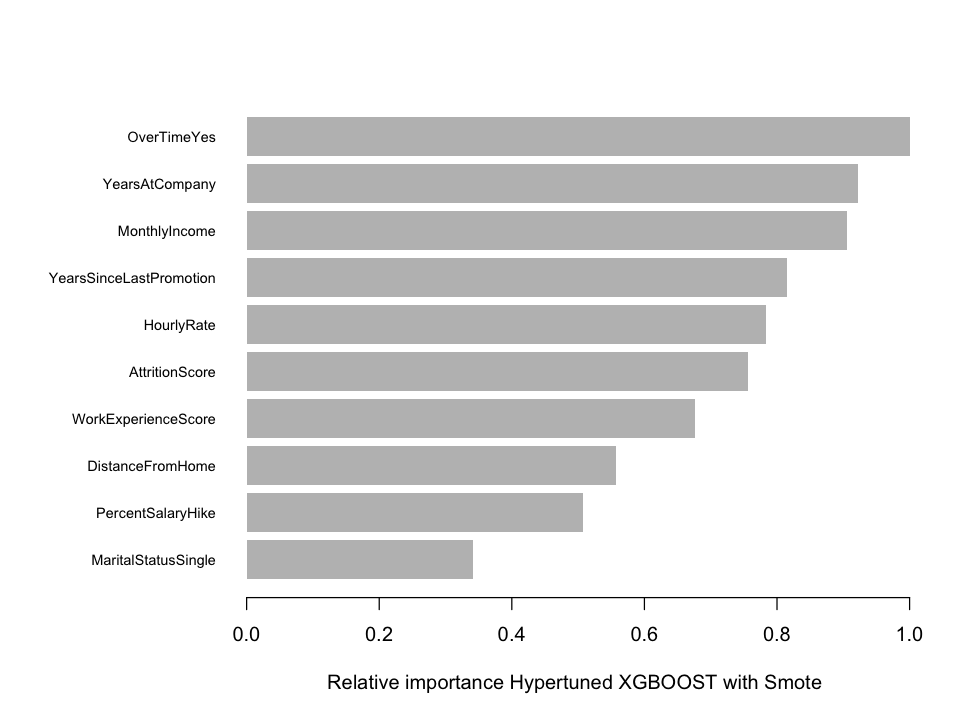

In [216]:
#Feature importance plot for base xgboost model
smote.tuned.mat <- xgb.importance (feature_names = colnames(smote.tuned.new_train),model = smote.tuned.xgb)
xgb.plot.importance (importance_matrix = smote.tuned.mat[1:10] , rel_to_first = TRUE, xlab = "Relative importance Hypertuned XGBOOST with Smote"  ) 

In [217]:
smote.tuned.test$Attrition <- as.numeric(smote.tuned.test$Attrition)-1

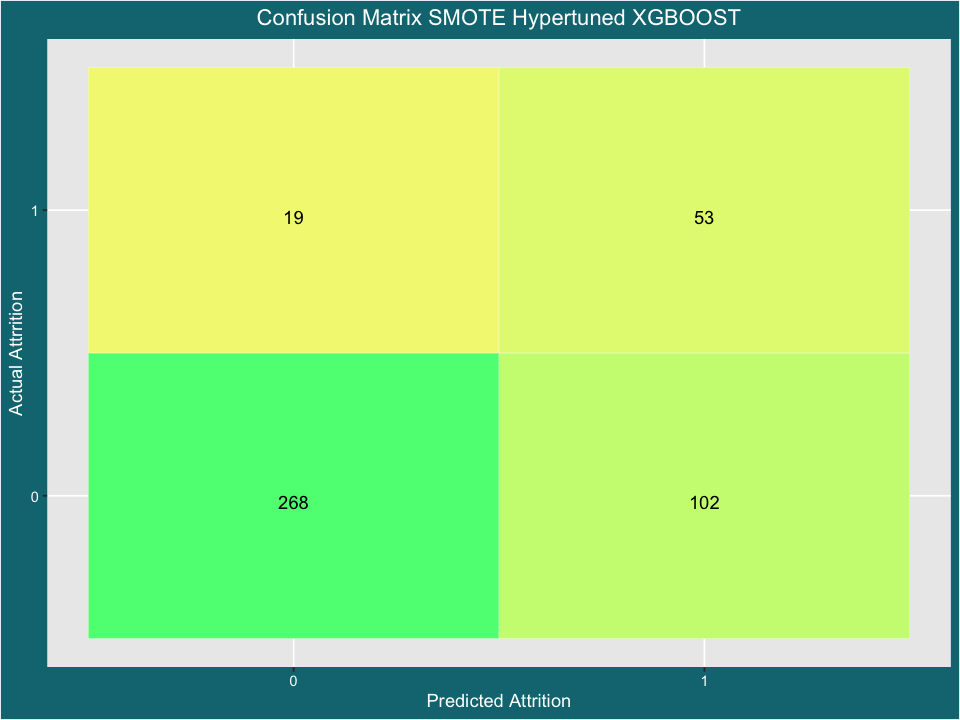

In [244]:
options(repr.plot.width=8, repr.plot.height=6) 
 
#store table results in conf_df
conf_df <- data.frame(table(smote.tuned.test$Attrition, smote.tuned.xgbpred))

#plotting of confusion matrix using ggplot2 library
ggplot(data =  conf_df, mapping = aes(x = smote.tuned.xgbpred, y = Var1)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "#F3F781", high = "#58FA82") + theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
     plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(colour="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix SMOTE Hypertuned XGBOOST", y="Actual Attrrition", x="Predicted Attrition")

In [219]:
xgb.plot.tree(model=smote.tuned.xgb, tree=0)

HTML widgets cannot be represented in plain text (need html)

In [220]:
xgb.plot.tree(model=smote.tuned.xgb, tree=1)

HTML widgets cannot be represented in plain text (need html)

In [221]:
#store table of predicted and actual values
smote.tuned.cmxgboost<- table(smote.tuned.test$Attrition, smote.tuned.xgbpred)

In [222]:
smote.xgboost.hypertunedaccuracy <- model.accuracy(smote.tuned.cmxgboost)

In [223]:
#apply recall formula on yes cases of attrtiion
smote.xgboost.hypertunedrecallYes <- AttritionYes.recall(smote.tuned.cmxgboost)

In [224]:
#apply precision formula on yes cases of attrtiion
smote.xgboost.hypertunedprecisionYes <- AttritionYes.precision(smote.tuned.cmxgboost)

In [225]:
#calculate F1 Score for yes cases of attrtiion
smote.xgboost.hypertuned_F1ScoreYes <- round((2 * smote.xgboost.hypertunedprecisionYes * smote.xgboost.hypertunedrecallYes) / (smote.xgboost.hypertunedrecallYes
                                                                                    +smote.xgboost.hypertunedprecisionYes) ,digits=2)

In [226]:
#apply recall formula on no cases of attrtiion
smote.xgboost.hypertunedrecallNo <- AttritionNo.recall(smote.tuned.cmxgboost)

In [227]:
#apply precision formula on no cases of attrtiion
smote.xgboost.hypertunedprecisionNo <- AttritionNo.precision(smote.tuned.cmxgboost)

In [228]:
#calculate F1 Score for no cases of attrtiion
smote.xgboost.hypertuned_F1ScoreNo <- round((2 * smote.xgboost.hypertunedprecisionNo * smote.xgboost.hypertunedrecallNo) / (smote.xgboost.hypertunedrecallNo
                                                                                    +smote.xgboost.hypertunedprecisionNo) ,digits=2)

In [229]:
total.recall.smote.hypertuned_XGBoost<- total.recall(smote.tuned.cmxgboost)  #apply total recall formula (both cases of attrtiion)
total.precision.smote.hypertunedXGBoost <- total.precision(smote.tuned.cmxgboost)  #apply total precision formula (both cases of attrtiion)
total.F1Score.smote.hypertunedXGBoost<- round((smote.xgboost.hypertuned_F1ScoreYes +
                                               smote.xgboost.hypertuned_F1ScoreNo)/2,digits=2)  #calculate total F1 Score (both cases of attrtiion)

In [230]:
BaseModelAttrition <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN")
Accuracy <- c(dectree.baseaccuracy, dectree.hypertunedaccuracy,postprunetree.baseaccuracy,xgboost.baseaccuracy, xgboost.hypertunedaccuracy, knn.hypertunedaccuracy )
Recall <- c(total.recall.basetree, total.recall.hypertunedtree,total.recall.postprunetree ,total.recall.base_XGBoost,total.recall.hypertuned_XGBoost,total.recall.hypertuned_knn)
Precision <- c(total.precision.basetree, total.precision.hypertunedtree,total.precision.postprunetree,total.precision.base_XGBoost, total.precision.hypertunedXGBoost, total.precision.hypertuned_knn )
F1Score <- c(total.F1Score.basetree,total.F1Score.hypertunedtree,total.F1Score.postprunetree,total.F1Score.base_XGBoost,total.F1Score.hypertunedXGBoost,total.F1Scoreknn)


In [231]:
AttritionResults <- data.frame(BaseModelAttrition,Accuracy ,Recall  , Precision , F1Score )
AttritionResults 

BaseModelAttrition                 Accuracy Recall Precision F1Score
1 Base Decision Tree                 0.84     0.65   0.71      0.68   
2 HyperTuned/PrePruned Decision Tree 0.85     0.56   0.77      0.63   
3 PostPruned Base Decison Tree       0.84     0.49   0.77      0.56   
4 Base XGBOOST                       0.87     0.67   0.80      0.72   
5 HyperTuned XGBOOST                 0.86     0.65   0.78      0.70   
6 HyperTuned KNN                     0.85     0.47   0.94      0.55

In [232]:
SmoteModelAttrition <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN" )
Smote.Accuracy <- c(smote.dectree.baseaccuracy, smote.dectree.hypertunedaccuracy,smote.postprunetree.baseaccuracy,smote.xgboost.baseaccuracy, smote.xgboost.hypertunedaccuracy, smote.knn.hypertunedaccuracy )
Smote.Recall <- c(total.recall.smote_basetree, total.recall.smote.hypertunedtree,total.recall.smote.postprunetree,total.recall.smote.base_XGBoost, total.recall.smote.hypertuned_XGBoost,total.recall.smote_knn)
Smote.Precision <- c(total.precision.smote_basetree, total.precision.smote.hypertunedtree,total.precision.smote.postprunetree,total.precision.smote.base_XGBoost,total.precision.smote.hypertunedXGBoost, total.precision.smote_knn )
Smote.F1Score <- c(total.F1Score.smote_basetree,total.F1Score.smote.hypertunedtree,total.F1Score.smote.postprunetree,total.F1Score.smote.base_XGBoost,total.F1Score.smote.hypertunedXGBoost,total.F1Score.smote_knn)
 

In [233]:
AttritionSmoteResults <- data.frame(SmoteModelAttrition ,Smote.Accuracy ,Smote.Recall,Smote.Precision , Smote.F1Score )
AttritionSmoteResults

SmoteModelAttrition                Smote.Accuracy Smote.Recall
1 Base Decision Tree                 0.63           0.81        
2 HyperTuned/PrePruned Decision Tree 0.65           0.82        
3 PostPruned Base Decison Tree       0.67           0.81        
4 Base XGBOOST                       0.67           0.81        
5 HyperTuned XGBOOST                 0.73           0.83        
6 HyperTuned KNN                     0.54           0.75        
  Smote.Precision Smote.F1Score
1 0.44            0.55         
2 0.46            0.58         
3 0.47            0.59         
4 0.47            0.59         
5 0.53            0.64         
6 0.37            0.48

In [234]:
BaseModelAttritionYes <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN")
Yes.Recall <- c(dectree.baserecallYes, dectree.hypertunedrecallYes,postprunetree.baserecallYes,xgboost.baserecallYes, xgboost.hypertunedrecallYes,knn.hypertunedrecallYes )
Yes.Precision <- c(dectree.baseprecisionYes, dectree.hypertunedprecisionYes,postprunetree.baseprecisionYes,xgboost.baseprecisionYes, xgboost.hypertunedprecisionYes, knn.hypertunedprecisionYes )
Yes.F1_Score<- c(dectree.base_F1ScoreYes, dectree.hypertuned_F1ScoreYes,postprunetree.base_F1ScoreYes,xgboost.base_F1ScoreYes, xgboost.hypertuned_F1ScoreYes, knn.hypertuned_F1ScoreYes )
 


In [235]:
AttritionYesResults <- data.frame(BaseModelAttritionYes, Yes.Recall  , Yes.Precision  , Yes.F1_Score )
AttritionYesResults

BaseModelAttritionYes              Yes.Recall Yes.Precision Yes.F1_Score
1 Base Decision Tree                 0.42       0.50          0.46        
2 HyperTuned/PrePruned Decision Tree 0.25       0.58          0.35        
3 PostPruned Base Decison Tree       0.12       0.56          0.20        
4 Base XGBOOST                       0.44       0.65          0.52        
5 HyperTuned XGBOOST                 0.40       0.60          0.48        
6 HyperTuned KNN                     0.10       0.88          0.18

In [236]:
BaseModelAttritionNo <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN")
No.Recall <- c(dectree.baserecallNo, dectree.hypertunedrecallNo,postprunetree.baserecallNo,xgboost.baserecallNo, xgboost.hypertunedrecallNo,knn.hypertunedrecallNo )
No.Precision <- c(dectree.baseprecisionNo, dectree.hypertunedprecisionNo,postprunetree.baseprecisionNo,xgboost.baseprecisionNo, xgboost.hypertunedprecisionNo, knn.hypertunedprecisionNo )
No.F1_Score<- c(dectree.base_F1ScoreNo, dectree.hypertuned_F1ScoreNo,postprunetree.base_F1ScoreNo,xgboost.base_F1ScoreNo, xgboost.hypertuned_F1ScoreNo, knn.hypertuned_F1ScoreNo )
 

In [237]:
AttritionNoResults <- data.frame(BaseModelAttritionNo ,No.Recall  , No.Precision  , No.F1_Score )
AttritionNoResults

BaseModelAttritionNo               No.Recall No.Precision No.F1_Score
1 Base Decision Tree                 0.89      0.92         0.90       
2 HyperTuned/PrePruned Decision Tree 0.87      0.96         0.91       
3 PostPruned Base Decison Tree       0.85      0.98         0.91       
4 Base XGBOOST                       0.90      0.95         0.92       
5 HyperTuned XGBOOST                 0.89      0.95         0.92       
6 HyperTuned KNN                     0.85      1.00         0.92

In [238]:
SmoteModelAttritionYes <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN")
Smote.RecallYes <- c(smote.dectree.baserecallYes, smote.dectree.hypertunedrecallYes,smote.postprunetree.baserecallYes,smote.xgboost.baserecallYes, smote.xgboost.hypertunedrecallYes,smote.knn.hypertunedrecallYes )
Smote.PrecisionYes <- c(smote.dectree.baseprecisionYes, smote.dectree.hypertunedprecisionYes,smote.postprunetree.baseprecisionYes,smote.xgboost.baseprecisionYes, smote.xgboost.hypertunedprecisionYes, smote.knn.hypertunedprecisionYes )
Smote.F1_ScoreYes<- c(smote.dectree.base_F1ScoreYes, smote.dectree.hypertuned_F1ScoreYes,smote.postprunetree.base_F1ScoreYes,smote.xgboost.base_F1ScoreYes, smote.xgboost.hypertuned_F1ScoreYes, smote.knn.hypertuned_F1ScoreYes )
 

In [239]:
AttritionYesResultsSmote <- data.frame(SmoteModelAttritionYes , Smote.RecallYes,Smote.PrecisionYes ,Smote.F1_ScoreYes)
AttritionYesResultsSmote

SmoteModelAttritionYes             Smote.RecallYes Smote.PrecisionYes
1 Base Decision Tree                 0.71            0.26              
2 HyperTuned/PrePruned Decision Tree 0.72            0.28              
3 PostPruned Base Decison Tree       0.71            0.29              
4 Base XGBOOST                       0.71            0.29              
5 HyperTuned XGBOOST                 0.74            0.34              
6 HyperTuned KNN                     0.62            0.21              
  Smote.F1_ScoreYes
1 0.38             
2 0.40             
3 0.41             
4 0.41             
5 0.47             
6 0.31

In [240]:
AttritionYesResults

BaseModelAttritionYes              Yes.Recall Yes.Precision Yes.F1_Score
1 Base Decision Tree                 0.42       0.50          0.46        
2 HyperTuned/PrePruned Decision Tree 0.25       0.58          0.35        
3 PostPruned Base Decison Tree       0.12       0.56          0.20        
4 Base XGBOOST                       0.44       0.65          0.52        
5 HyperTuned XGBOOST                 0.40       0.60          0.48        
6 HyperTuned KNN                     0.10       0.88          0.18

In [241]:
SmoteModelAttritionNo <- c("Base Decision Tree", "HyperTuned/PrePruned Decision Tree", 'PostPruned Base Decison Tree',
                "Base XGBOOST", "HyperTuned XGBOOST",
                "HyperTuned KNN")
Smote.RecallNo <- c(smote.dectree.baserecallNo, smote.dectree.hypertunedrecallNo,smote.postprunetree.baserecallNo,smote.xgboost.baserecallNo, smote.xgboost.hypertunedrecallNo,smote.knn.hypertunedrecallNo)
Smote.PrecisionNo <- c(smote.dectree.baseprecisionNo, smote.dectree.hypertunedprecisionNo,smote.postprunetree.baseprecisionNo,smote.xgboost.baseprecisionNo, smote.xgboost.hypertunedprecisionNo, smote.knn.hypertunedprecisionNo )
Smote.F1_ScoreNo<- c(smote.dectree.base_F1ScoreNo, smote.dectree.hypertuned_F1ScoreNo,smote.postprunetree.base_F1ScoreNo,smote.xgboost.base_F1ScoreNo, smote.xgboost.hypertuned_F1ScoreNo, smote.knn.hypertuned_F1ScoreNo )
 

In [242]:
AttritionNoResultsSmote <- data.frame(SmoteModelAttritionNo ,Smote.RecallNo,Smote.PrecisionNo  ,Smote.F1_ScoreNo )